In [1]:
import random
import math
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ambulance_game.simulation import (
    simulate_model,
    get_average_simulated_state_probabilities,
)

from ambulance_game.markov import (
    visualise_markov_chain,
    is_accepting_state,
    build_states,
    get_transition_matrix,
    get_steady_state_algebraically,
    get_markov_state_probabilities,
)

# Simulation

In [3]:
from ambulance_game.simulation import(
    extract_total_individuals_and_the_ones_within_target_for_both_classes,
    get_mean_proportion_of_individuals_within_target_for_multiple_runs,
)

# Utils functions

In [4]:
from ambulance_game.markov.utils import(
    get_probability_of_accepting,
    get_proportion_of_individuals_not_lost,
)

# Markov Chains

In [5]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
threshold = 5
system_capacity = 20
buffer_capacity = 10

target = 4

In [6]:
visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

Error in callback <function flush_figures at 0x00000258F17DE5E0> (for post_execute):


KeyboardInterrupt: 

## Theory:

- **Sum of exponentially distributed random varables (with the same parameter $\lambda$) results in Erlang distributed R.V.** 

    $$
        X_i \sim Exp(\lambda) \qquad \Rightarrow \qquad S = X_1 + X_2 + \dots + X_k \sim Erlang(k, \lambda)
    $$

- **Sum of erlang distributed random varables (with different parameters $\lambda$) results in Hypoexponentially distributied R.V.**

    $$
        S_i \sim Erlang(k_i, \lambda_i) \qquad \Rightarrow \qquad H = S_1 + S_2 + \dots + S_n \sim Hypo((k_1, \dots, k_n), (\lambda_1, \dots, \lambda_n)) \\
    $$


**Applied to Markov chain**

$S_7 = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} + X_{0,2}$

$X_{0,2}$ has a different exponential parameter than the other ones and cannot be combined to form Erlang distribution

By just considering the waiting time (excluding service time):

$S_{0,7} = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} \sim Erlang(n, \lambda)$

$P(S_{0,7} < 4) = 1 - \sum_{i=0}^{n-1} \frac{e^{-4\lambda} (4 \lambda)^i}{i!}$

## Function for JUST waiting time  (NOT USED)

In [ ]:
# Function for just waiting time
def get_probability_of_waiting_time_in_system_less_than_target_for_state_just_wait(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        param = num_of_servers * mu
        prob = 1 - np.sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        prob = 1

    return prob

## Function for total time in system by adjusting $C\mu$ in $Erlang(n, C\mu)$ (NOT USED)

$$
C \tilde \mu = \frac{1}{\frac{1}{C \mu} + \frac{1}{n \mu}} \qquad \Rightarrow \qquad S \sim Erlang(n, \frac{1}{\frac{1}{C \mu} + \frac{1}{n \mu}})
$$

In [ ]:
def get_probability_of_waiting_time_in_system_less_than_target_for_state_adj_mu(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        param = 1 / (1 / (num_of_servers * mu) + (1 / (mu * k)))
        prob = 1 - np.sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        param = mu
        prob = 1 - np.exp(- param * target)

    return prob

## Function for total time in system by adjusting $n$ in $Erlang(n, C\mu)$ (NOT USED)

$$
    \tilde n = n + C \qquad \Rightarrow \qquad S \sim Erlang(n + C, C\mu)
$$

In [ ]:
def get_probability_of_waiting_time_in_system_less_than_target_for_state_adj_k(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        k = k + num_of_servers
        param = num_of_servers * mu
        prob = 1 - sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        param = mu
        prob = 1 - np.exp(- param * target)

    return prob

## Getting the distribution of $X_1 + \dots + X_n + X_s$

- **Using Erlang Distribution**: Sum of exponentially distributed random variables with the same parameter 
    $$
    X_1 , \dots \ X_n \sim Exp(C\mu) \quad \left( \Rightarrow X_1 + \dots + X_n \sim Erlang(n, C\mu) \right) \\
    X_s \sim Exp(\mu) \qquad \left( \Rightarrow X_s \sim Erlang(1, \mu) \right)
    $$
    
    - **CDF of $Erlang(n, \lambda)$:** 
        $$
        F(x) = 1 - \sum_{i=0}^{n-1} \frac{e^{-\lambda x} (\lambda x)^i}{i!}
        $$

- **Using Hypoexponential Ditribution**:
    $$
    \underbrace{
        X_1 , \dots \ X_n \sim Exp(C\mu), \qquad X_s \sim Exp(\mu)
    } \\
    X_1 + \dots + X_n + X_s \sim Hypo(C\mu, \dots, C\mu, \mu)
    $$
    
    - **CDF of $Hypo(\lambda_1, \dots, \lambda_N)$:**
    $$
    \begin{align}
        & F(x) = 1 - \left( \prod_{j=1}^a \lambda_j^{r_j} \right) \sum_{k=1}^a \sum_{l=1}^{r_k} \frac{\Psi_{k,l}(-\lambda_k)x^{r_k - l} e^{-\lambda_k x}}
        {(r_k - l)! (l - 1)!} \\ 
        & \textbf{where} \qquad \Psi_{k,l}(t) = - \frac{\partial^{l - 1}}{\partial t ^{l - 1}} \left( \prod_{j = 0, j \neq k}^a (\lambda_j + t)^{-r_j} \right) \\
        & \textbf{and} \quad \qquad \lambda_0 = 0, r_0 = 1
    \end{align}
    $$

- **Specific CDF of $Hypo(\lambda_1, \dots, \lambda_N)$:**

    $$
        \Psi_{k,l}(t) = 
        \begin{cases} 
            \frac{(-1)^{l} (l-1)!}{t^l (t + \lambda_2)^l} 
            \times \sum_{j=1}^{l} {l \choose j} t^{l - j} \lambda_2 ^ {j - 1}, & k=1 \\
            - \frac{1}{t (t + \lambda_1)^{r_1}}, & k=2
        \end{cases}
    $$


- **Improved specific CDF of $Hypo(\lambda_1, \dots, \lambda_N)$:**
    $$
        \Psi_{k,l}(t) = 
        \begin{cases} 
            \frac{(-1)^{l} (l-1)!}{\lambda_2} \left[\frac{1}{t^l} - \frac{1}{(t + \lambda_2)^l}\right] , & k=1 \\
            - \frac{1}{t (t + \lambda_1)^{r_1}}, & k=2
        \end{cases}
    $$



## $\Psi$ functions 

In [ ]:
from ambulance_game.markov.proportion import(
    general_psi_function,
    specific_psi_function,
)


def specific_psi_function_old(arg, k, l, exp_rates, freq, a):
    psi_val = 0
    if k == 1:
        for term in range(1, l + 1):
            psi_val += math.comb(l, term) * arg ** (l - term) * exp_rates[2] ** (term - 1)
        psi_val *= (-1) ** l * math.factorial(l - 1) / (arg ** l * (arg + exp_rates[2]) ** l)
    if k == 2:
        psi_val = -1 / (arg * (arg + exp_rates[1]) ** freq[1])
    return psi_val

## Hypoexponential CDF function

In [ ]:
from ambulance_game.markov.proportion import hypoexponential_cdf

## Function to decide whether to use Exponential, Erlang or Hypoexponential

- If individual arrives on service (no wait):
$$
    X \sim Erlang(1, \mu)
$$

- If individual arrives on $n^{th}$ waiting space:
$$
    X \sim Hypo(\underbrace{C \mu, \dots, C \mu}_{n}, \mu)
$$

- If individual arrives on $n^{th}$ waiting space **AND** $C=1$:
$$
    X \sim Erlang(n + 1, \mu)
$$

In [ ]:
from ambulance_game.markov.proportion import erlang_cdf

In [ ]:
from ambulance_game.markov.proportion import get_probability_of_waiting_time_in_system_less_than_target_for_state

# Formula
$$
    P(W < 4) = \frac{\sum_{(u,v) \in S_A}^{} P(S_{u,v} < T) \pi_{u,v} }{\sum_{(u,v) \in S_A}^{} \pi_{u,v}}
$$

In [ ]:
from ambulance_game.markov.proportion import get_proportion_of_individuals_within_time_target

# Overall Proportion

In [ ]:
from ambulance_game.markov.proportion import overall_proportion_of_individuals_within_time_target

# Formula using Markov chain probs

In [ ]:
from ambulance_game.markov.proportion import proportion_within_target_using_markov_state_probabilities

# Formula using Simulation state probabilities

In [ ]:
from ambulance_game.comparisons import get_proportion_within_target_from_simulation_state_probabilities

# Plot comparison between simulation and Markov chains

In [ ]:
from ambulance_game.comparisons import plot_output_comparisons

# Plots comparing times in the system (class 1)

1. Base plot
2. By adjusting $\mu$
3. By adjusting $k$
4. Using Hypoexponential (np.prod)
5. Using Hypoexponential (np.math.prod)

In [ ]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = None
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Simulation time in system VS Markov waiting times

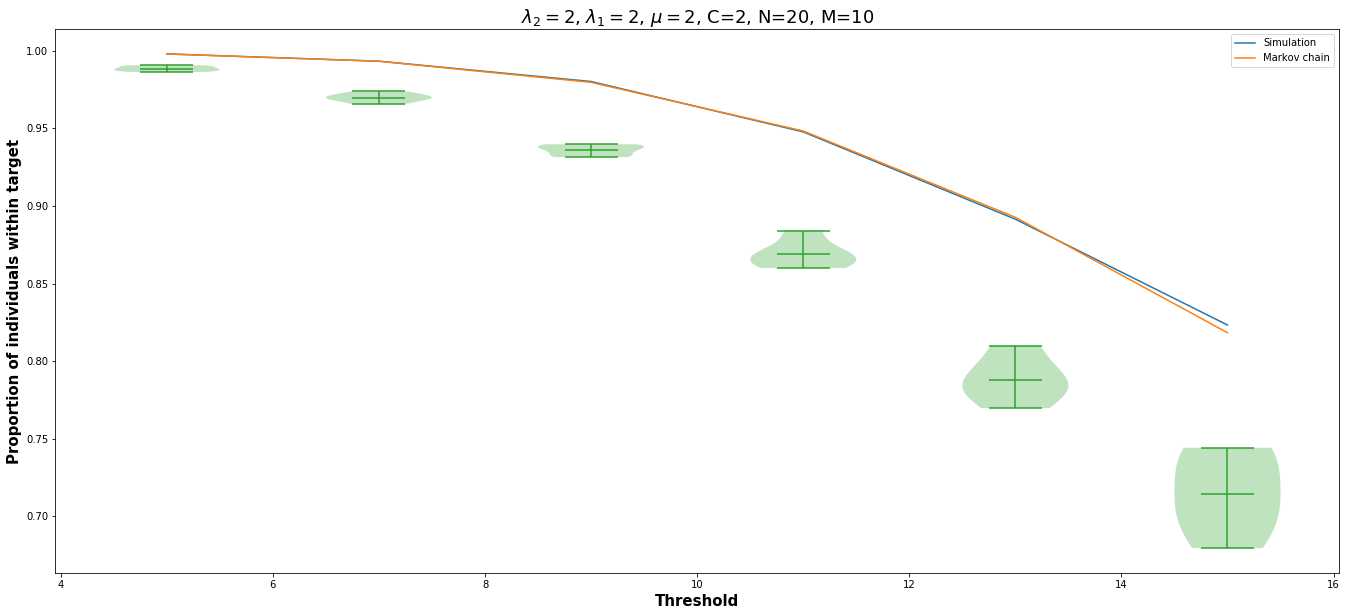

In [27]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (by adjusting $C\mu$ in $Erlang(k,C\mu)$)

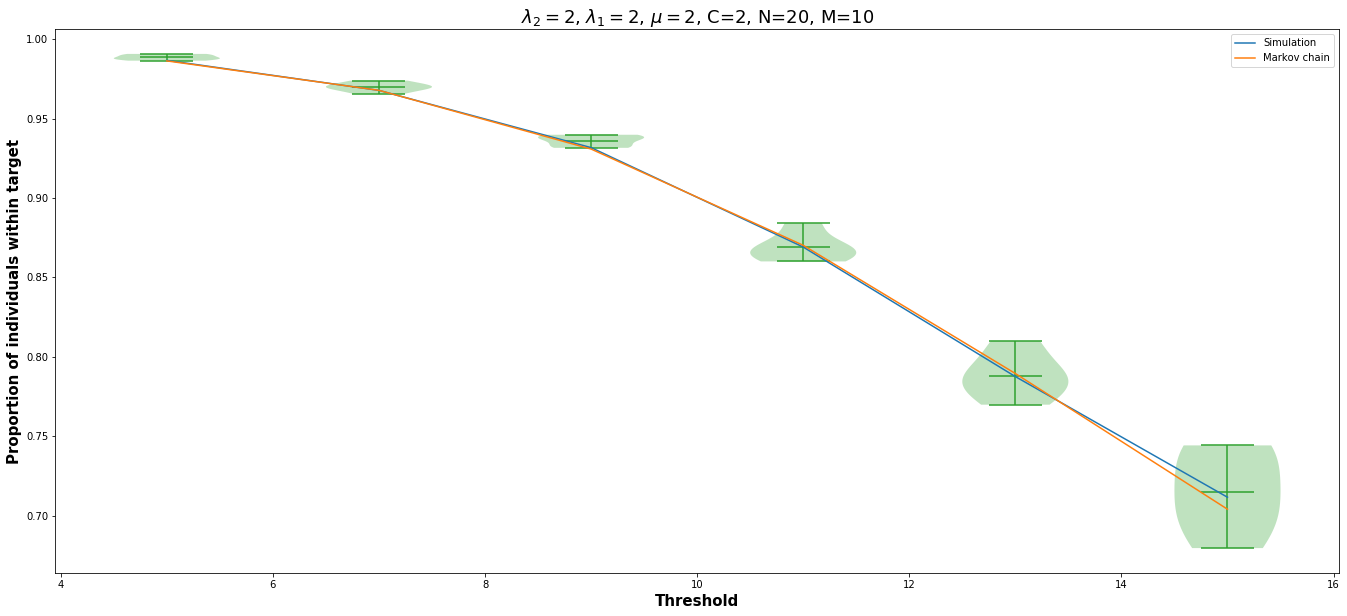

In [29]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (by adjusting $n$ in $Erlang(n,C\mu)$)

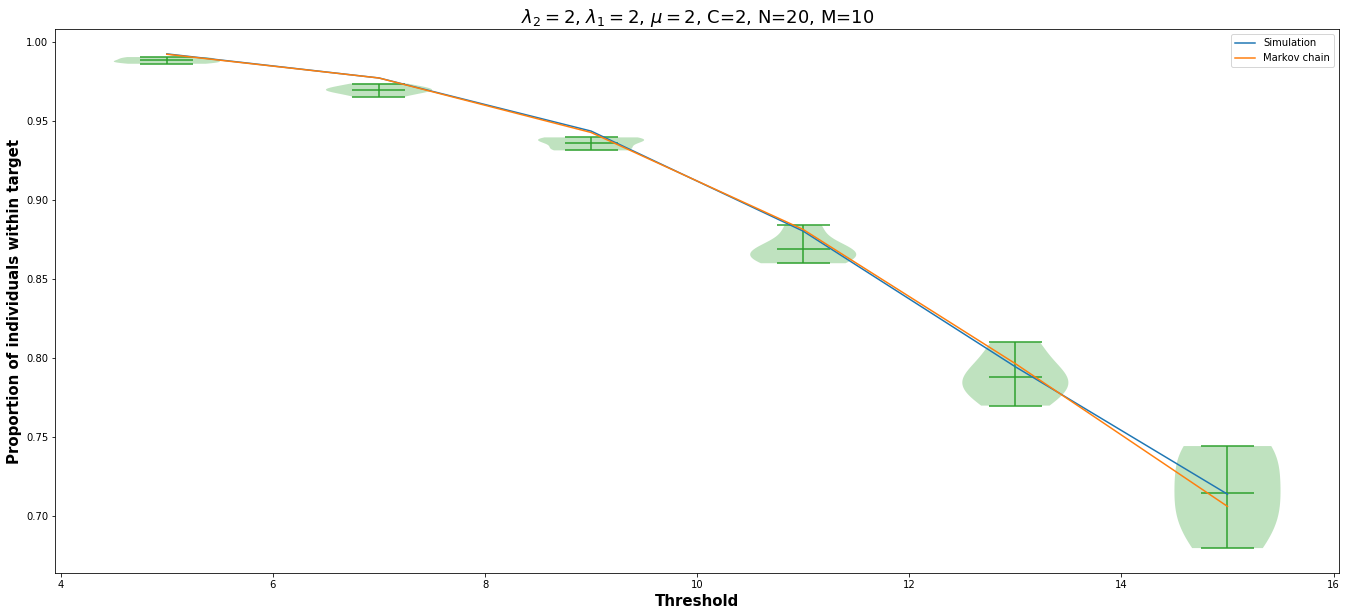

In [31]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (using $Hypo \sim (C\mu, \dots, C\mu, \mu)$ and numpy.prod())

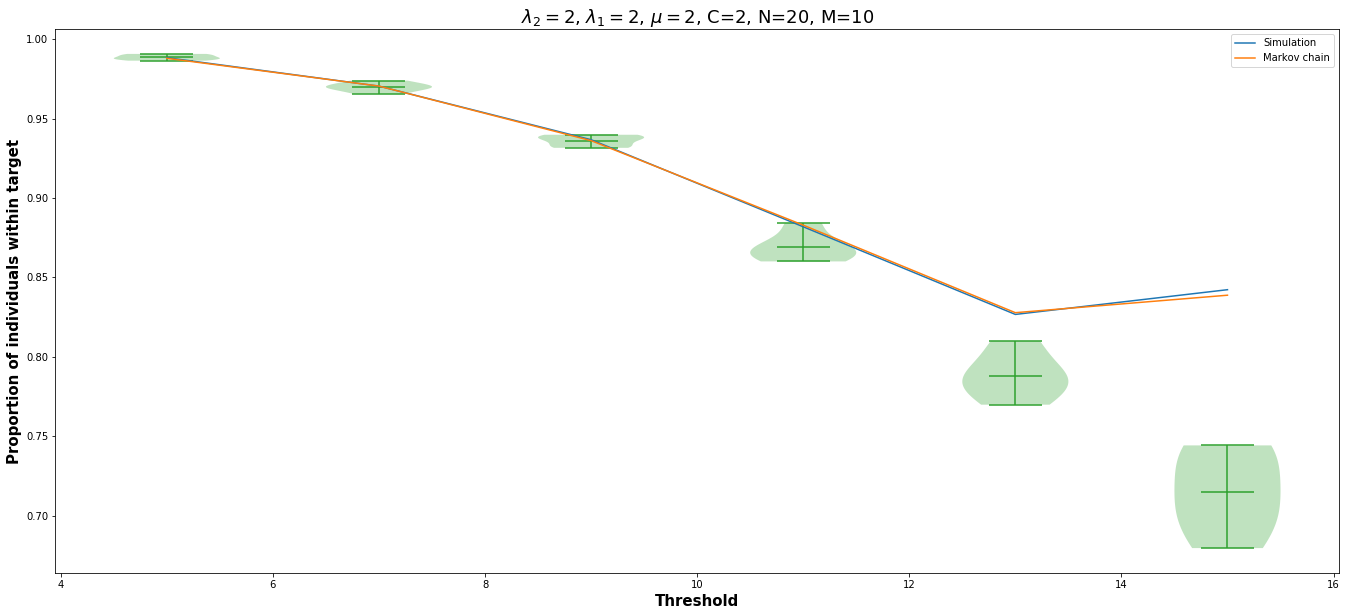

In [200]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (using $Hypo \sim (C\mu, \dots, C\mu, \mu)$ and numpy.math.prod())

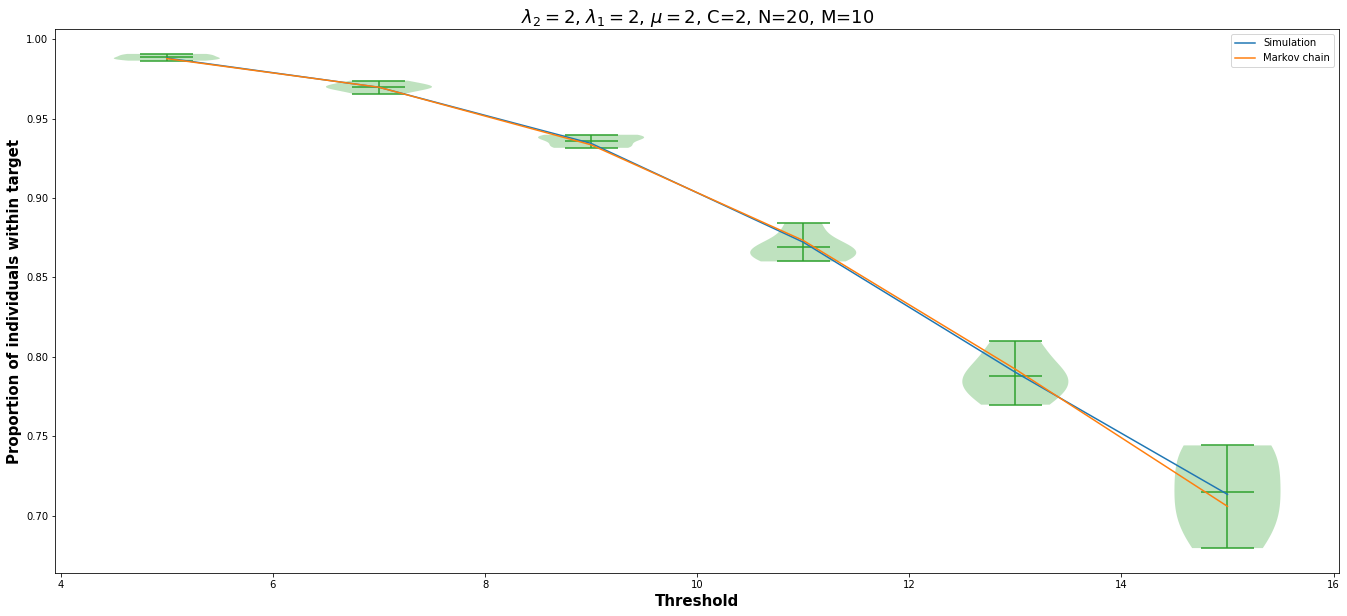

In [187]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

# Plots comparing times in the system (using non-linear cdf of Hypo.)

## $\lambda_1 = 2, \lambda_2 = 2, \mu = 2, C = 2, T_{\min} = 5, T_{\max} = 15, N = 20, M = 10$

In [21]:
lambda_1 = 2
lambda_2 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = 0
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Class 1

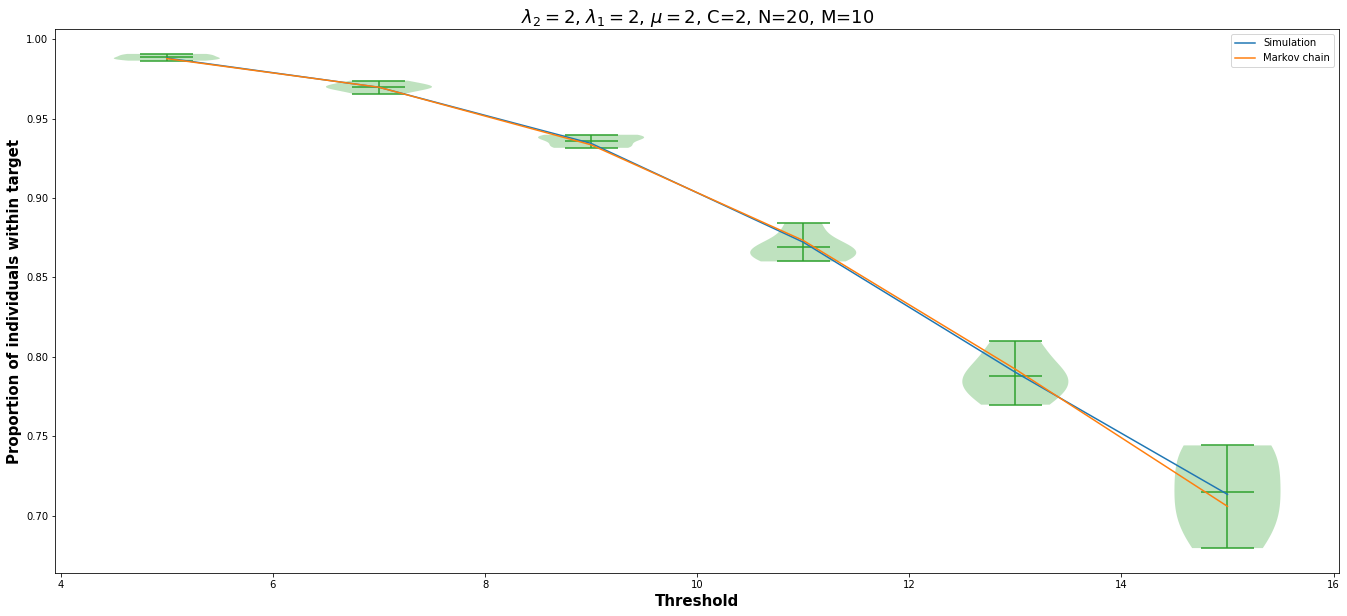

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

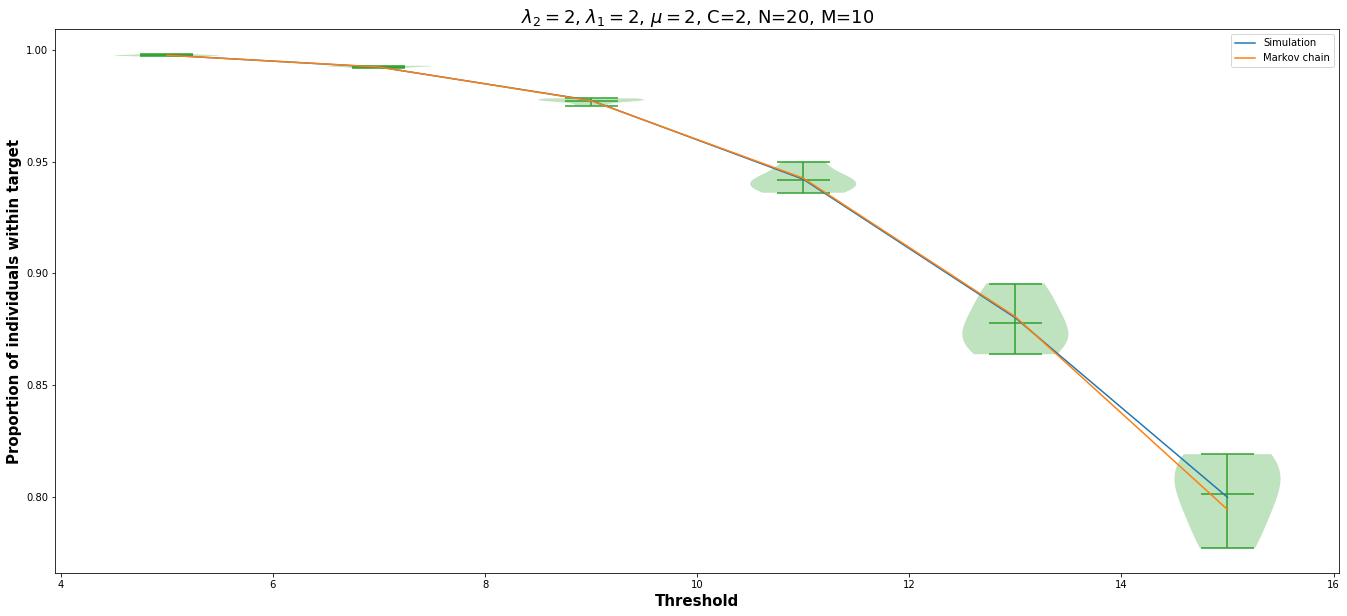

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

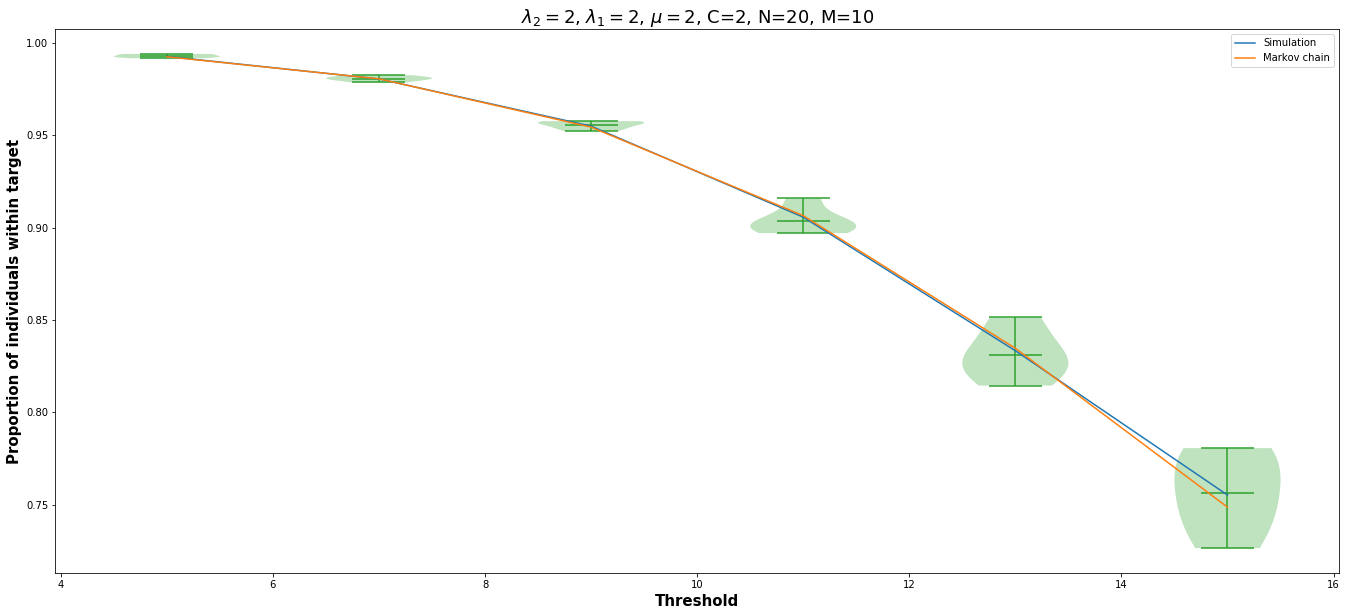

In [24]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 10, M = 10$

In [81]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 10
buffer_capacity = 10

seed_num = 1
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

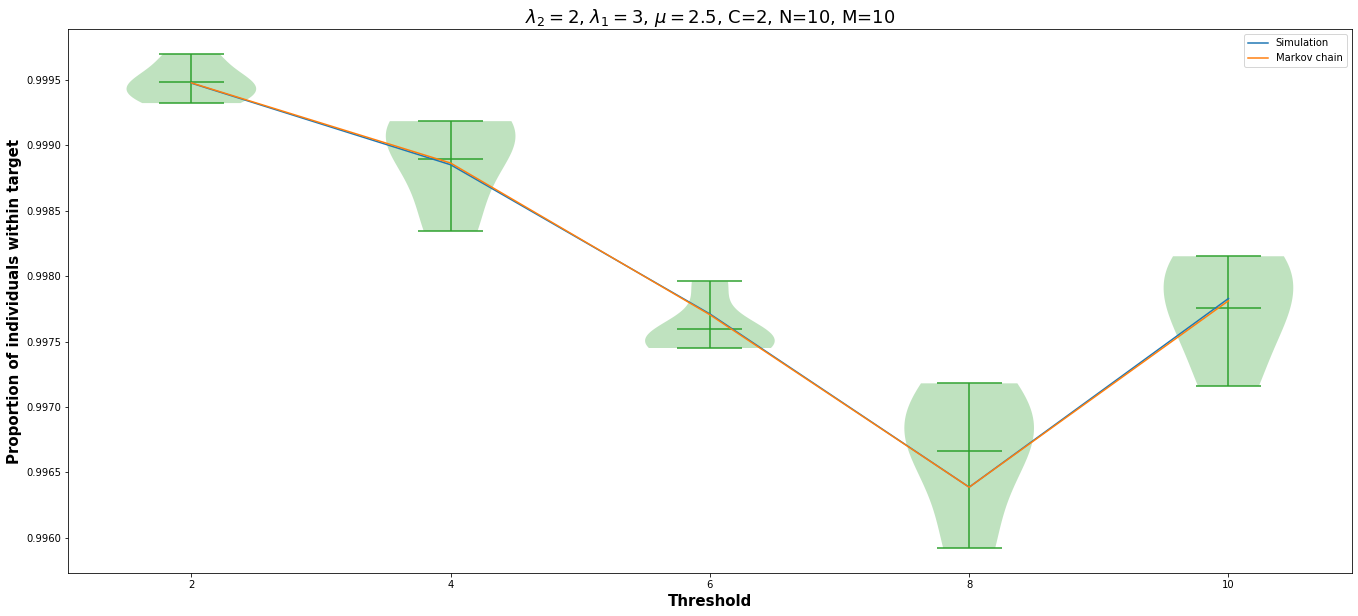

In [83]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

### General behaviour of $P(W_1 > target)$
- As the threshold increases the waiting time of class 1 patients should increase.
- As the waiting time of class 1 patients increases $P(W_1 < target)$ should decrease.
- $\Rightarrow$ As the threshold increases $P(W_1 < target)$ should decrease.

### **BUT** as the threshold gets close to the system capacity:
- Class 2 patients can take up more waiting spaces
- Class 1 patients get more frequently lost to the system
- Average waiting time of class 1 patients decreases
- As $W_1$ decreases $P(W_1 < target)$ increases

## Class 2

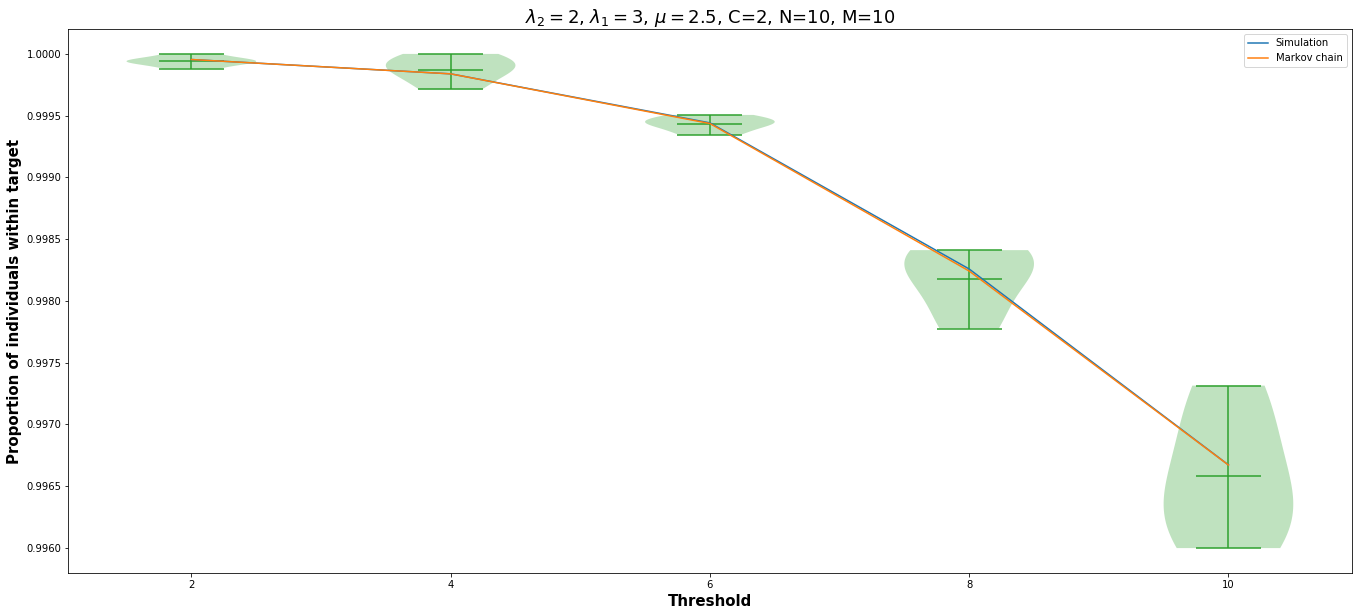

In [84]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

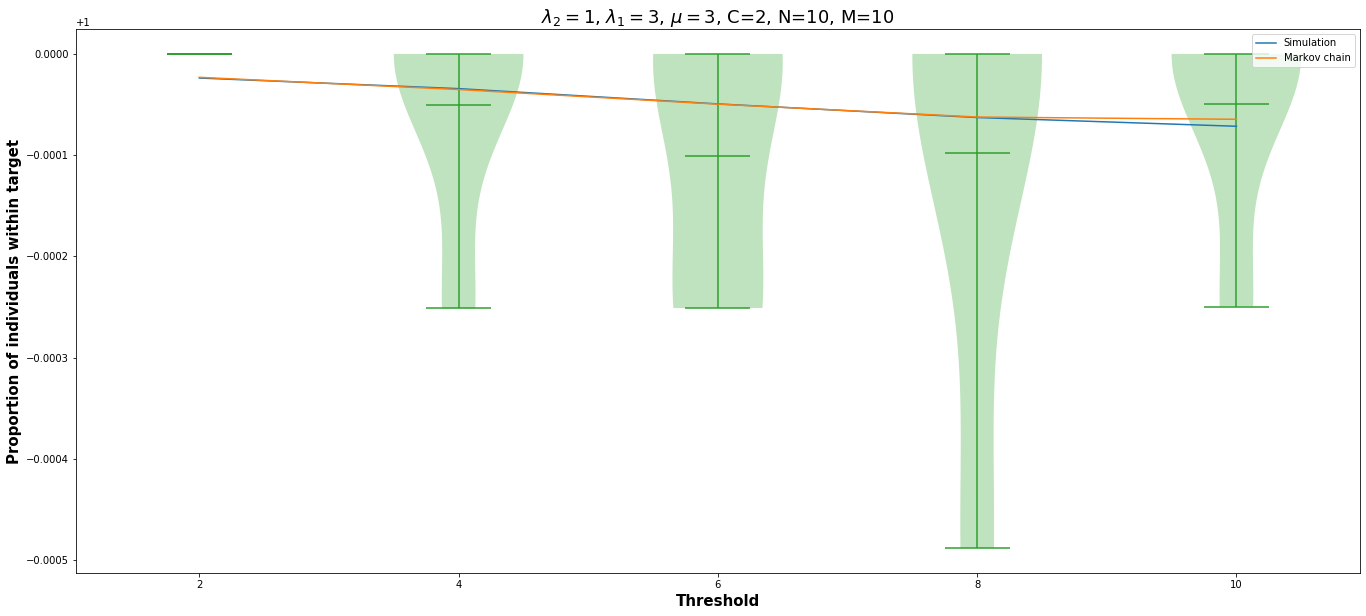

In [34]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 20, M = 10$

In [20]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

seed_num = 2
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

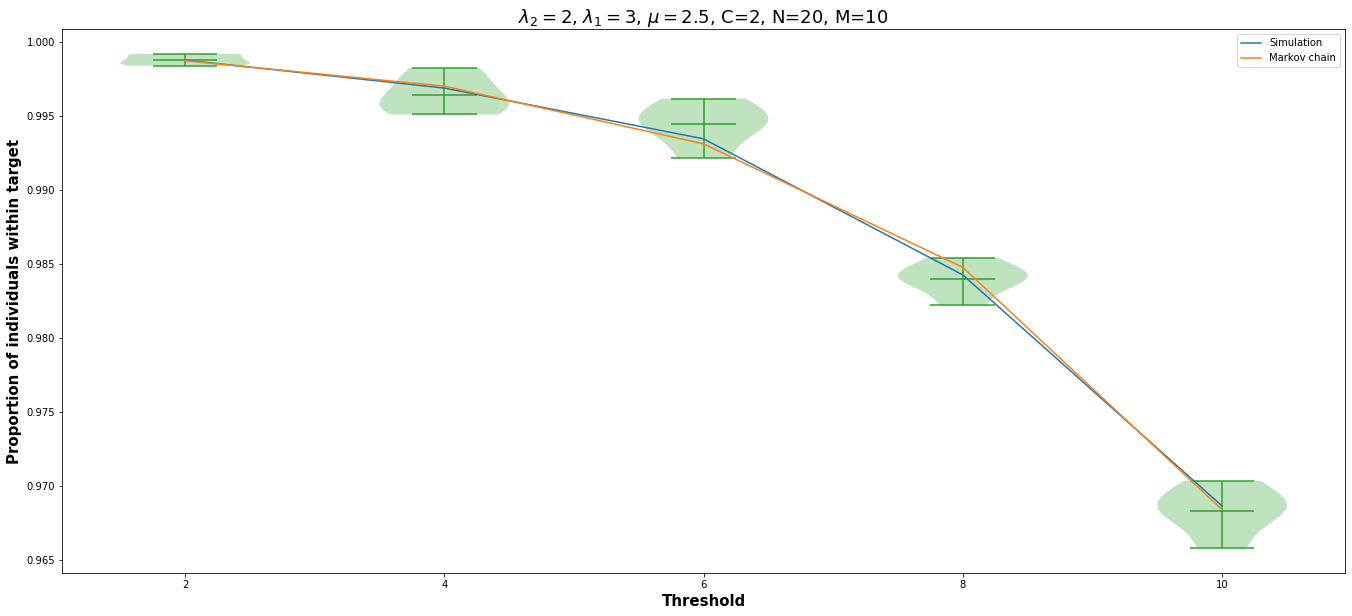

In [21]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

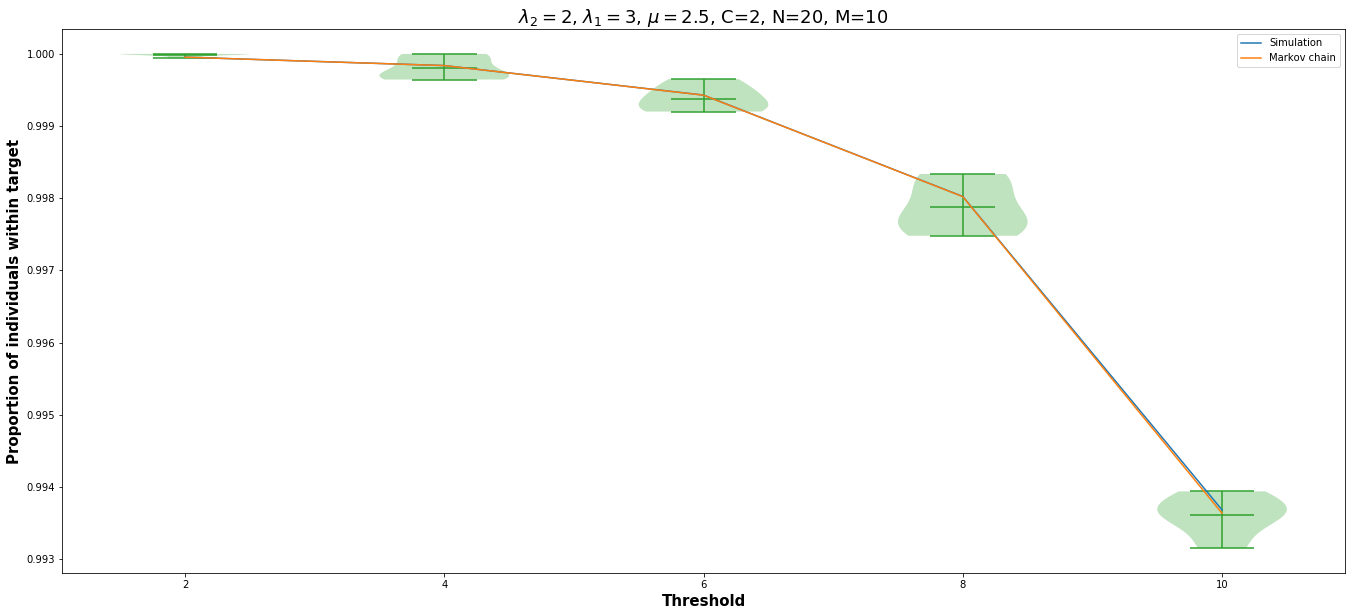

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

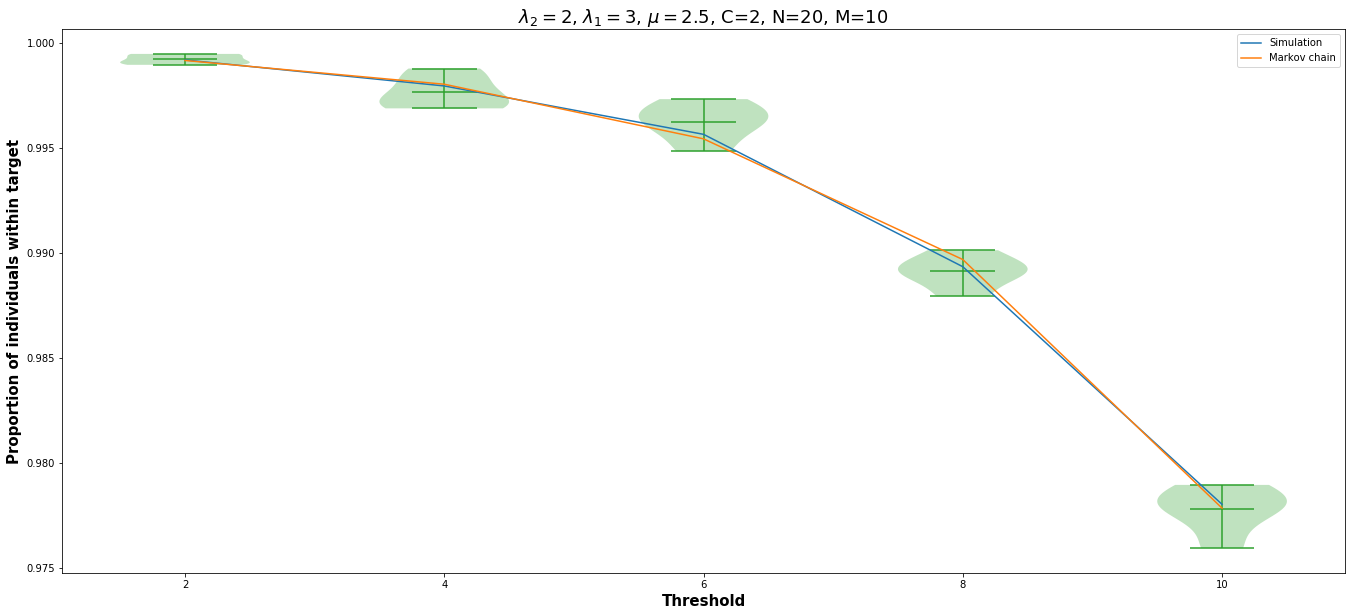

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = \frac{1}{2}, \lambda_2 = \frac{1}{2}, \mu = \frac{1}{2}, C = 3, T_{\min} = 2, T_{\max} = 6, N = 6, M = 5$

In [30]:
lambda_1 = 0.5
lambda_2 = 0.5
mu = 0.5

num_of_servers = 3
system_capacity = 6
buffer_capacity = 5

seed_num = 3
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 6
accuracy = 5
target = 4

## Class 1

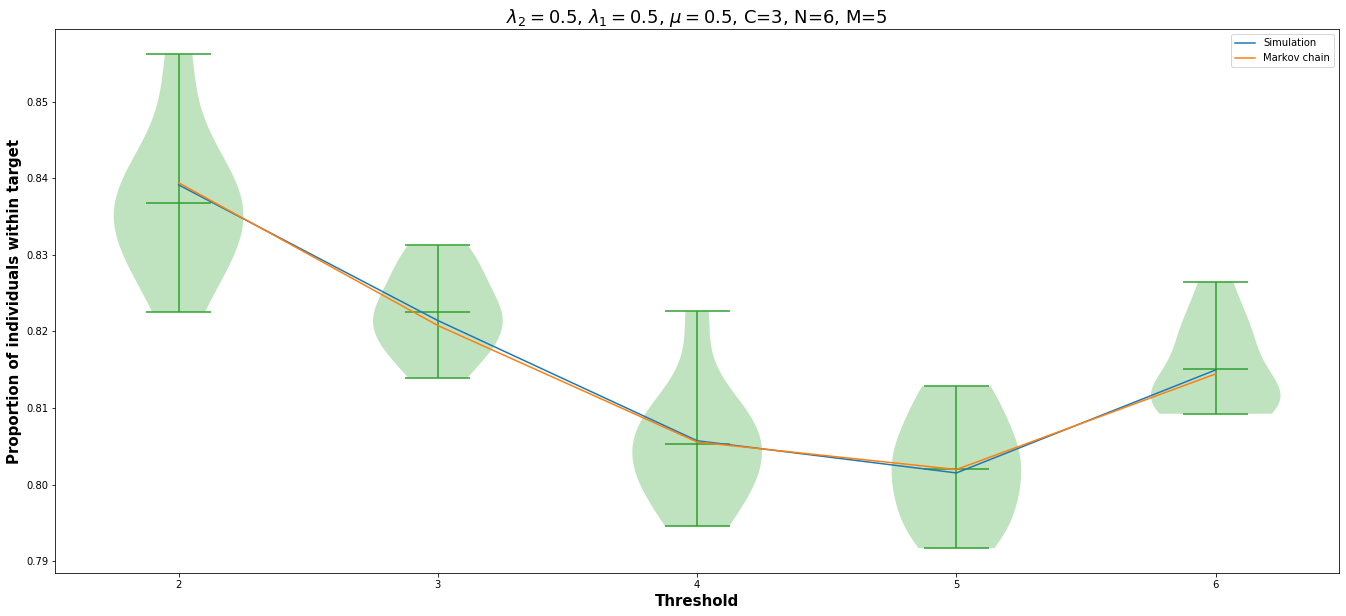

In [31]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

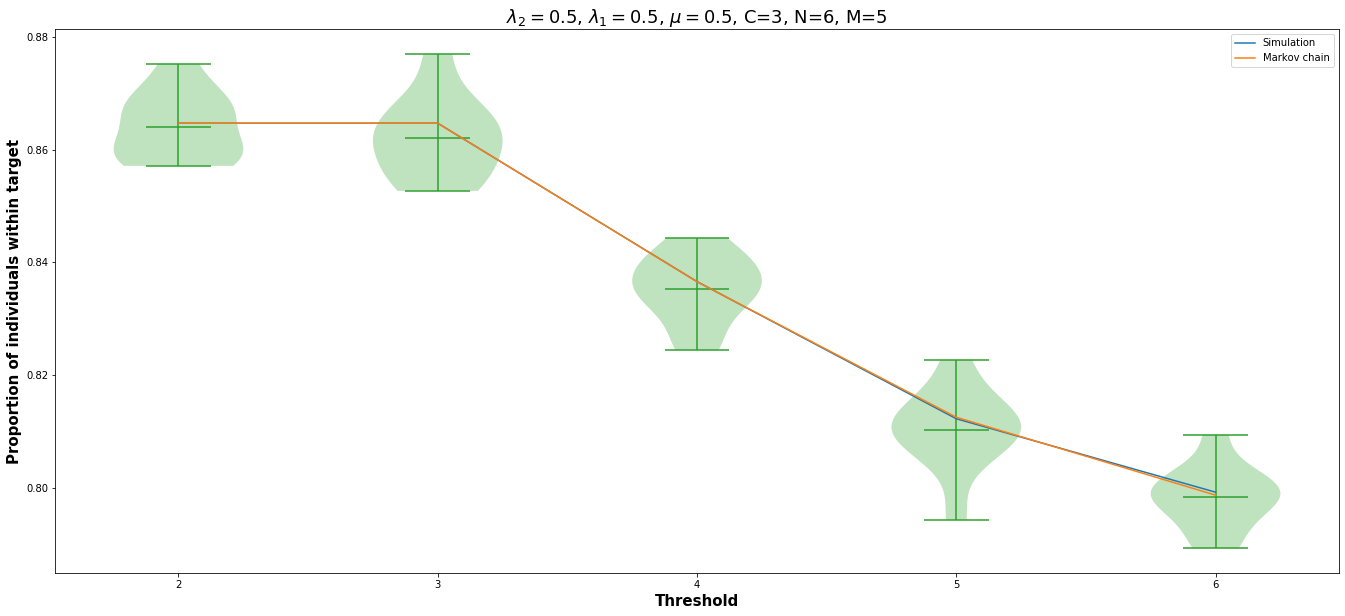

In [32]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

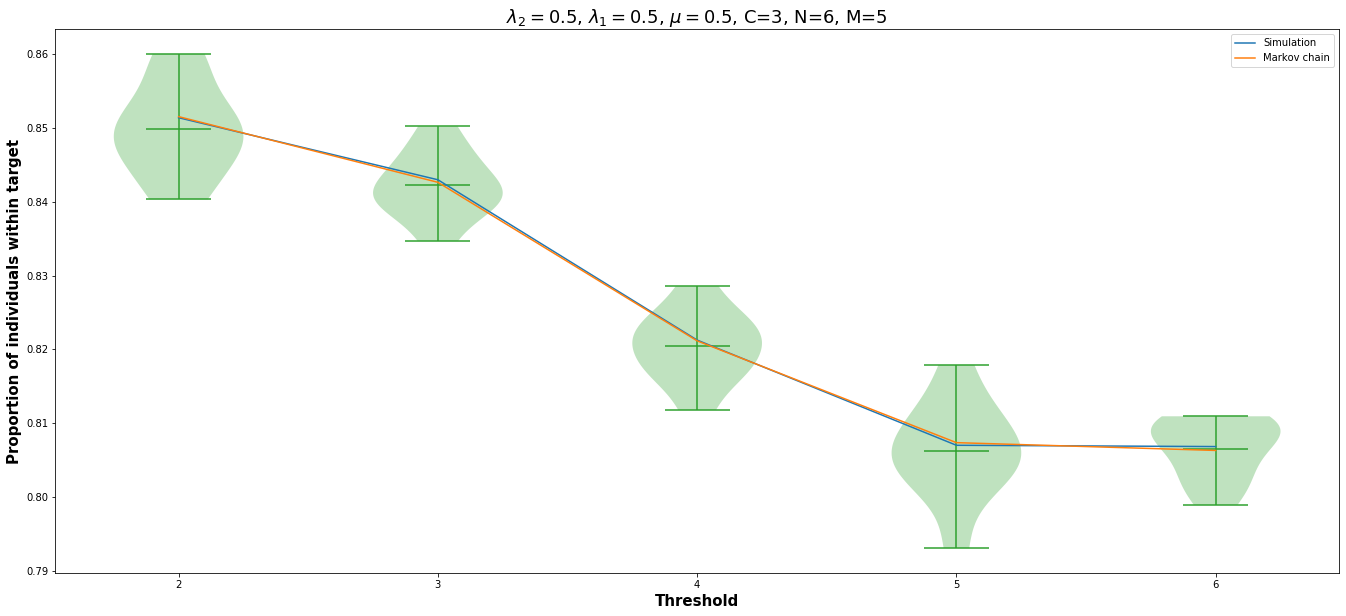

In [33]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 1, \lambda_2 = 2, \mu = 4, C = 1, T_{\min} = 2, T_{\max} = 10, N = 15, M = 15$

In [18]:
lambda_1 = 1
lambda_2 = 2
mu = 4

num_of_servers = 1
system_capacity = 15
buffer_capacity = 15

seed_num = None
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

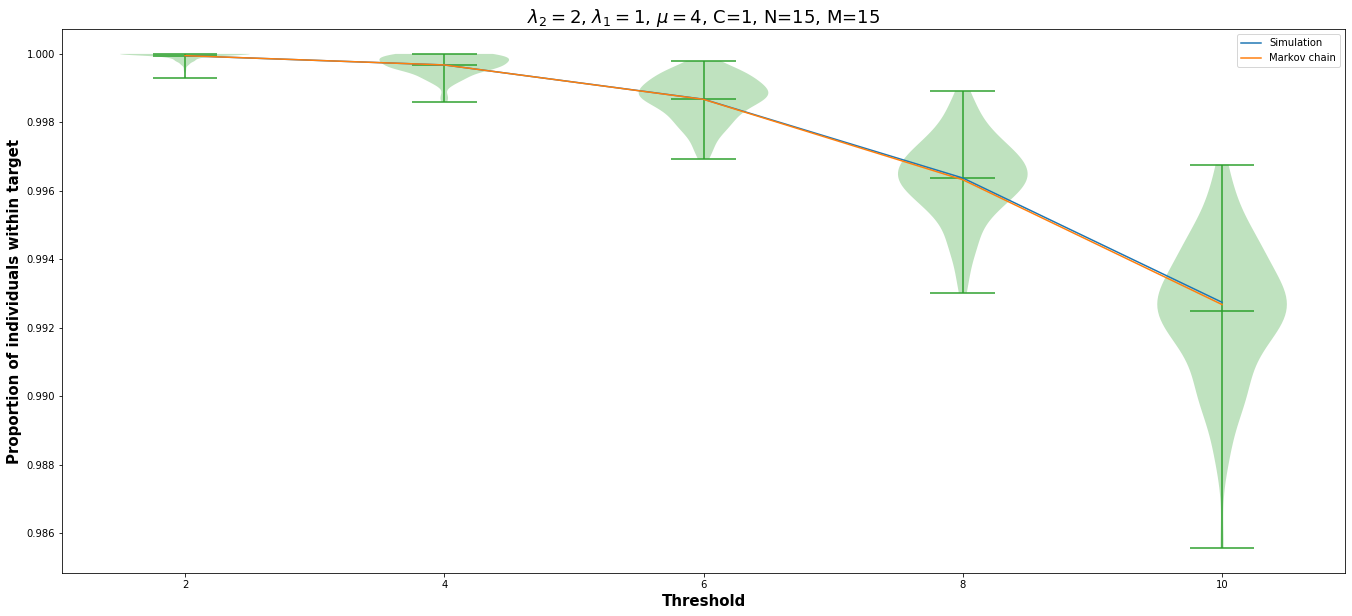

In [38]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

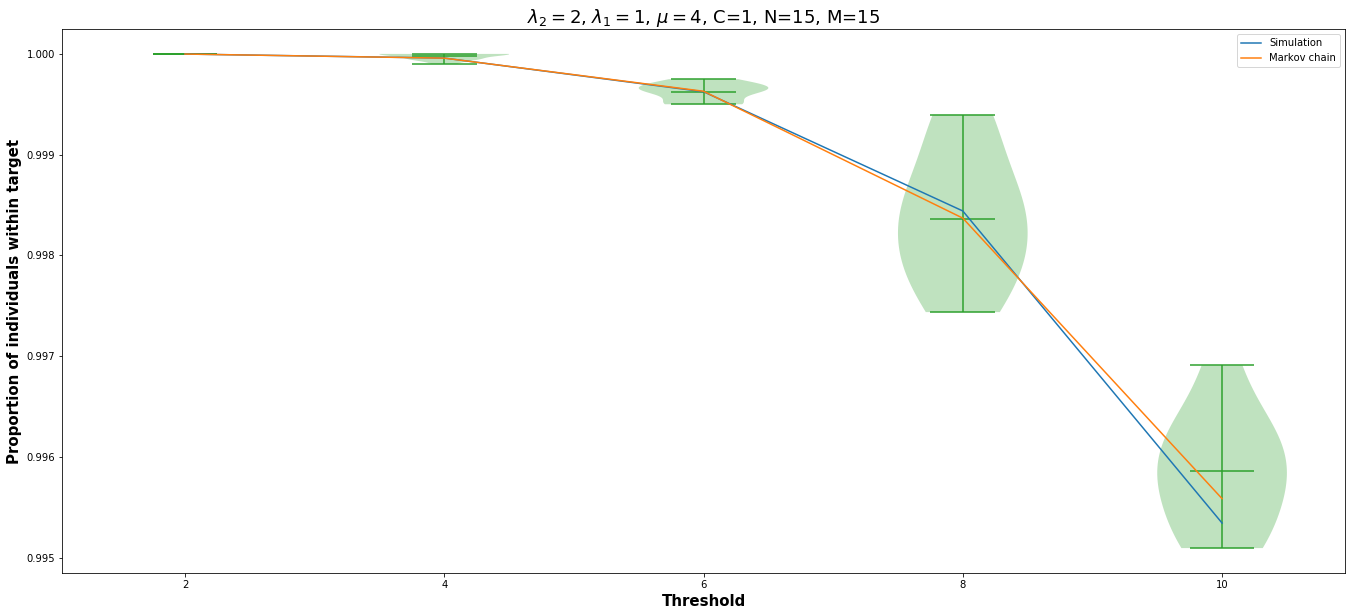

In [19]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes 

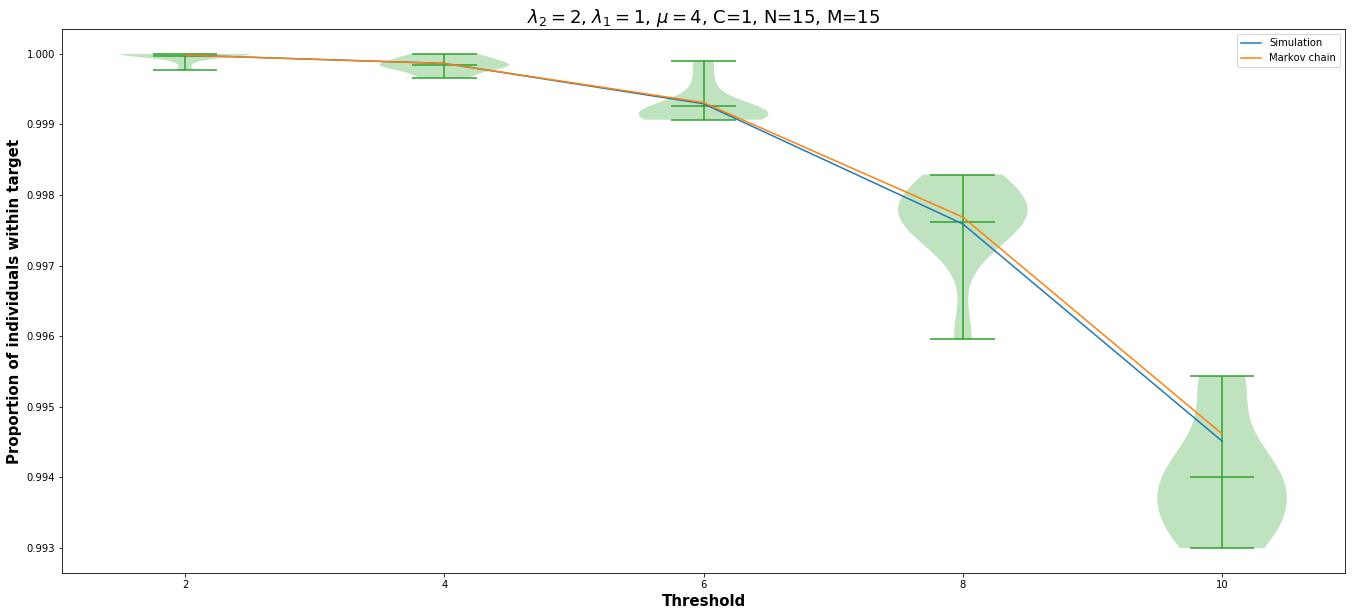

In [20]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

# Plots comparing times in the system (linear Hypo. formula)

## $\lambda_1 = 2, \lambda_2 = 2, \mu = 2, C = 2, T_{\min} = 5, T_{\max} = 15, N = 20, M = 10$

In [21]:
lambda_1 = 2
lambda_2 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = 0
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Class 1

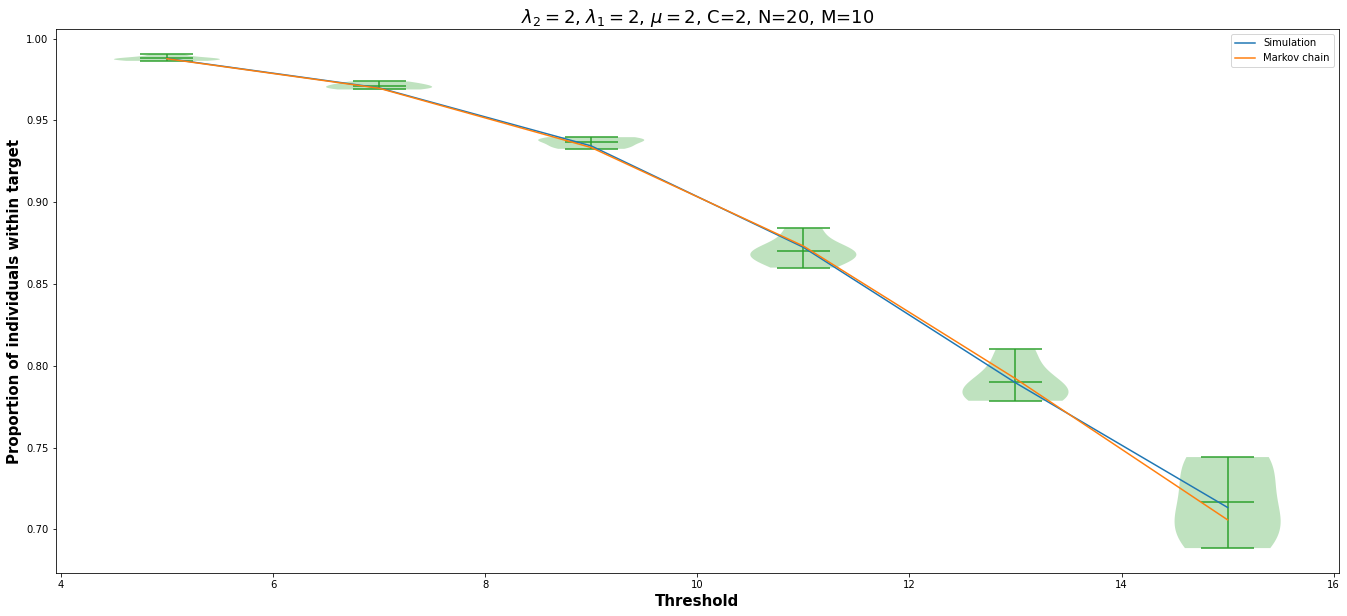

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

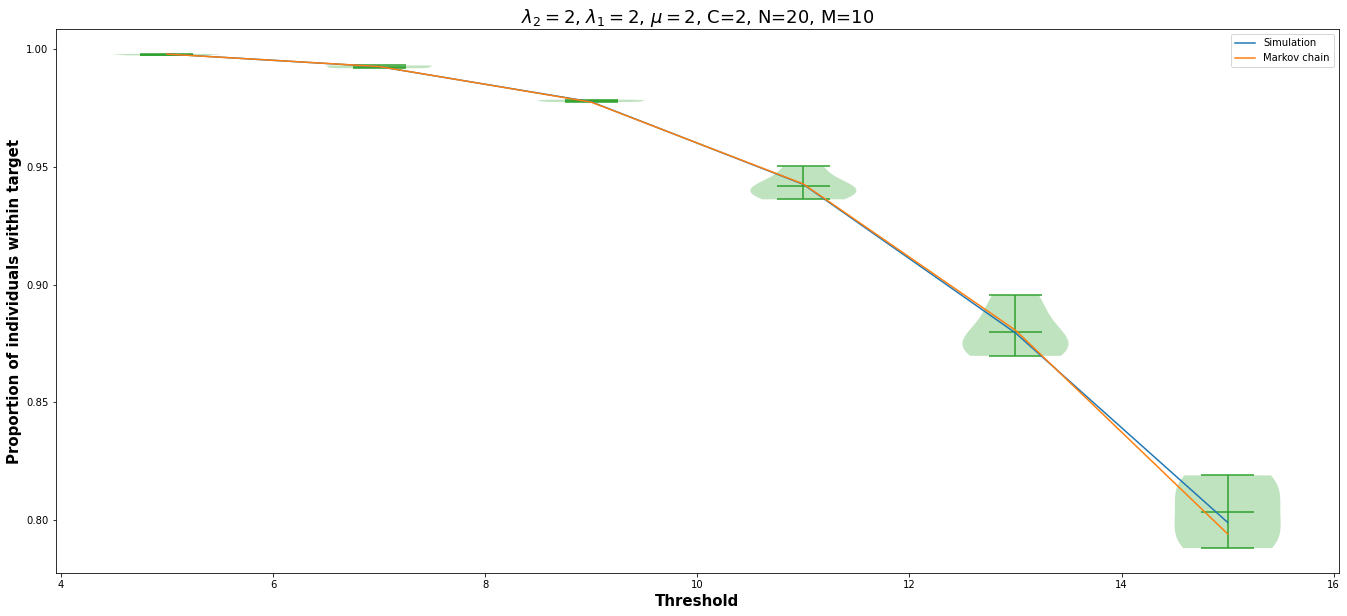

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

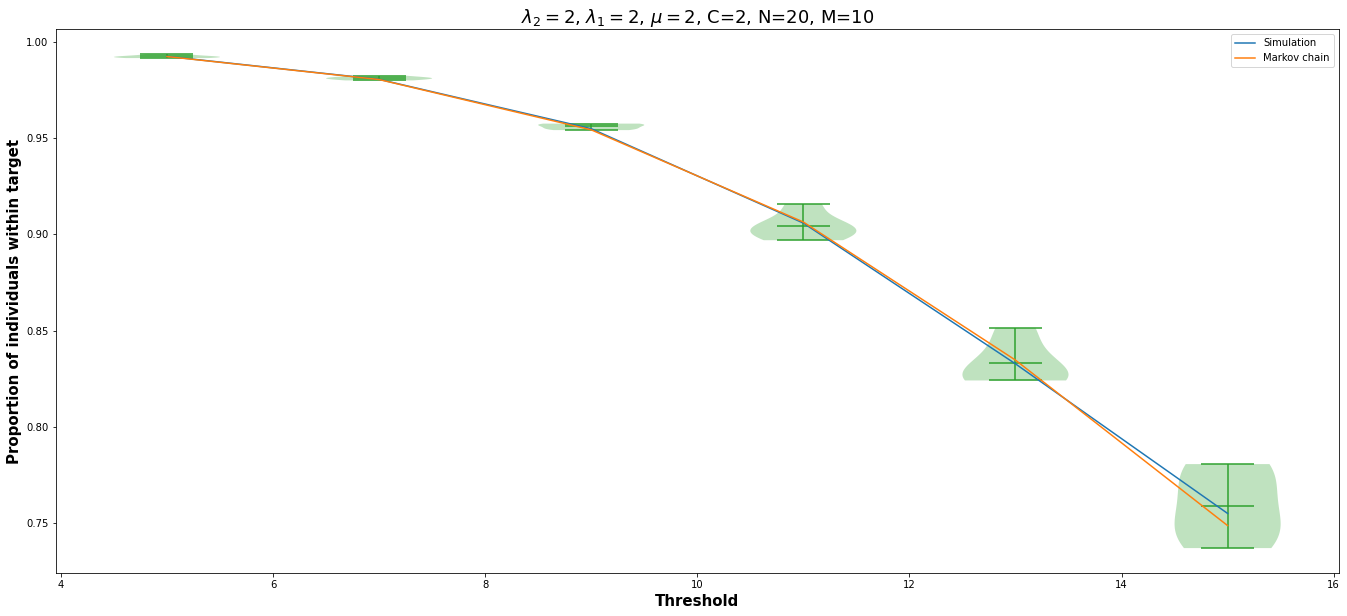

In [24]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 10, M = 10$

In [25]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 10
buffer_capacity = 10

seed_num = 1
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

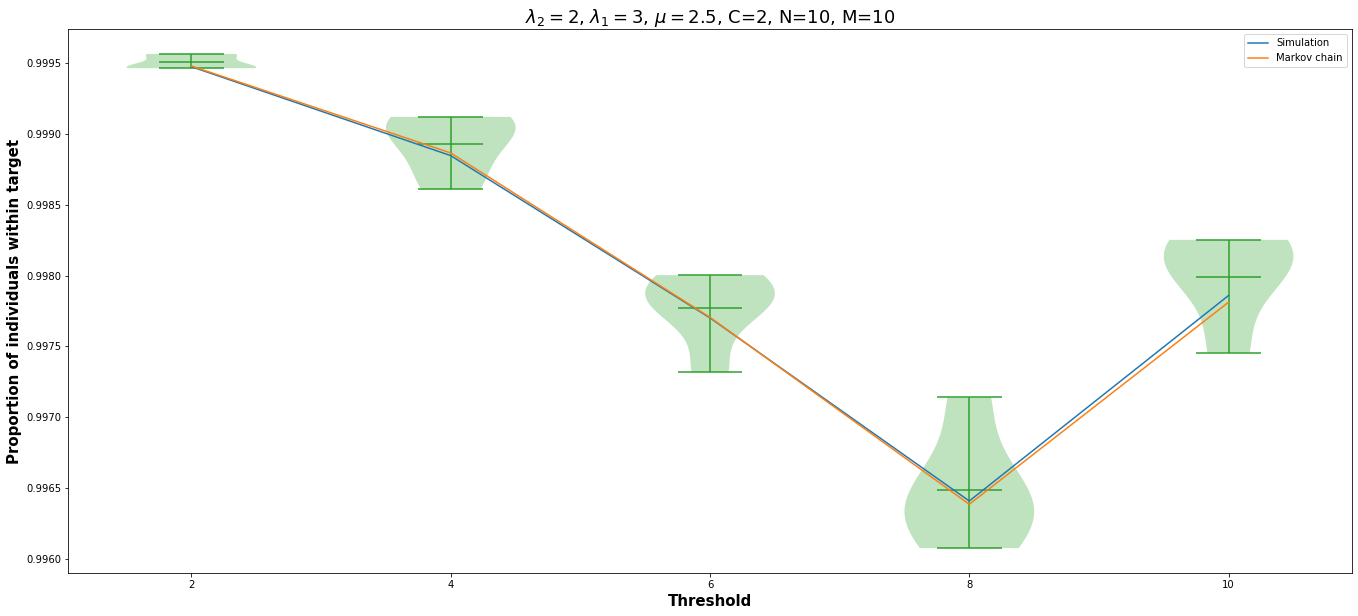

In [26]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

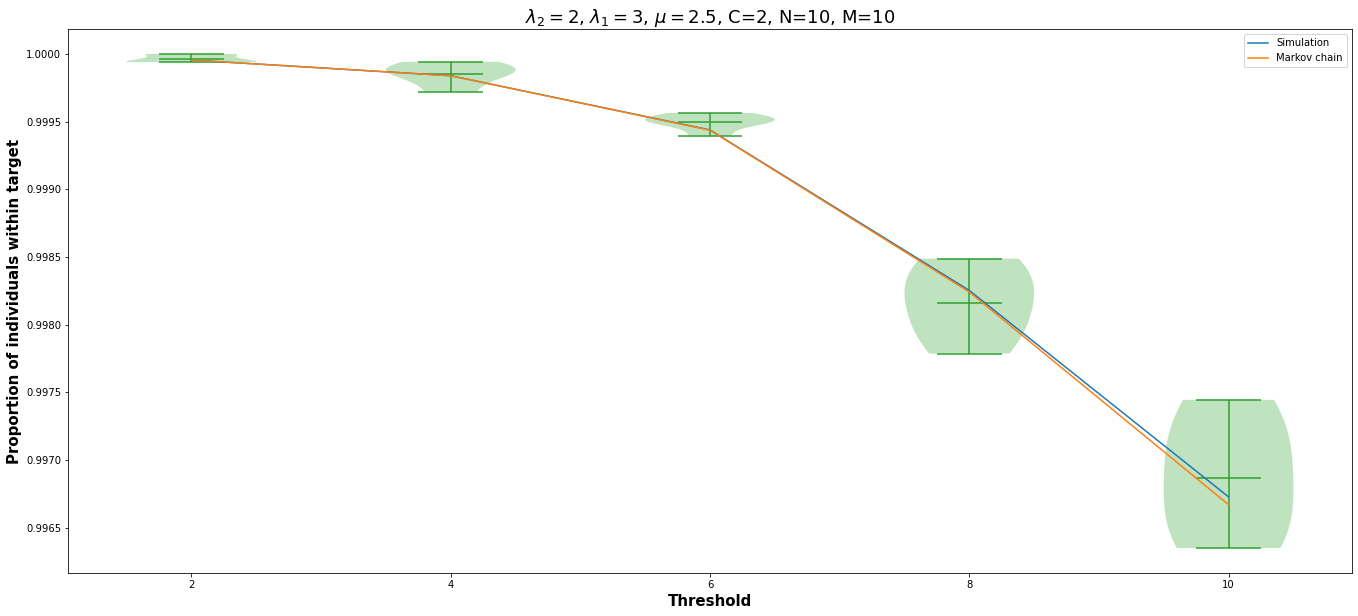

In [27]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

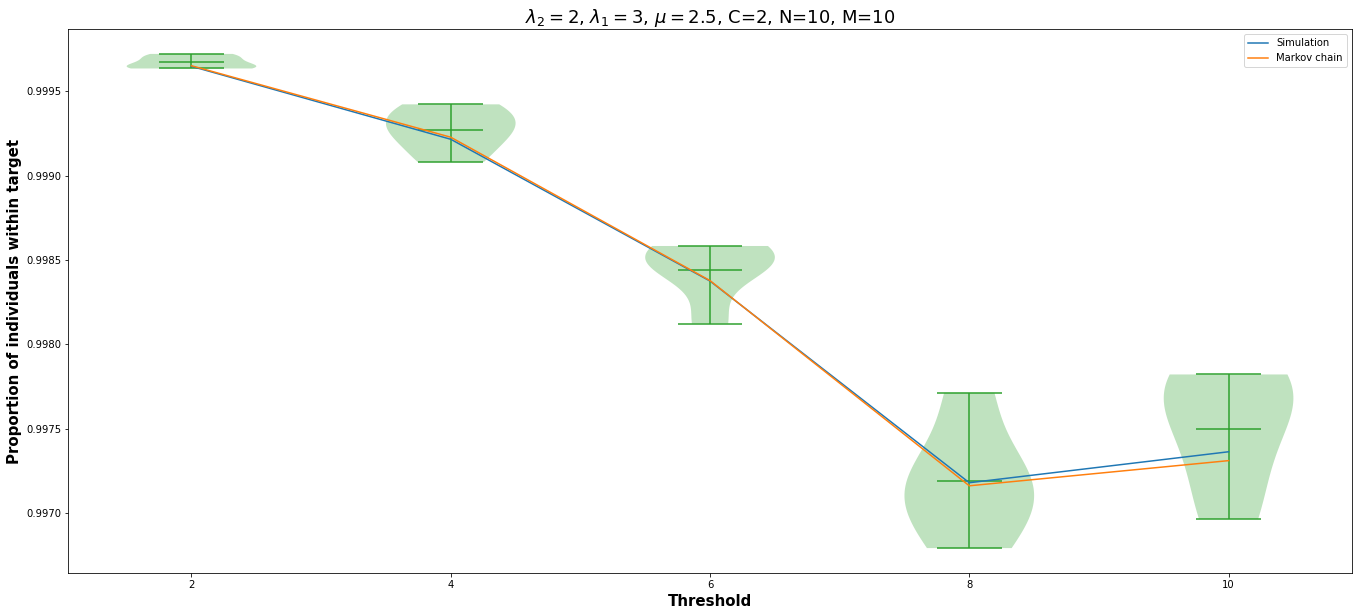

In [28]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 20, M = 10$

In [29]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

seed_num = 2
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

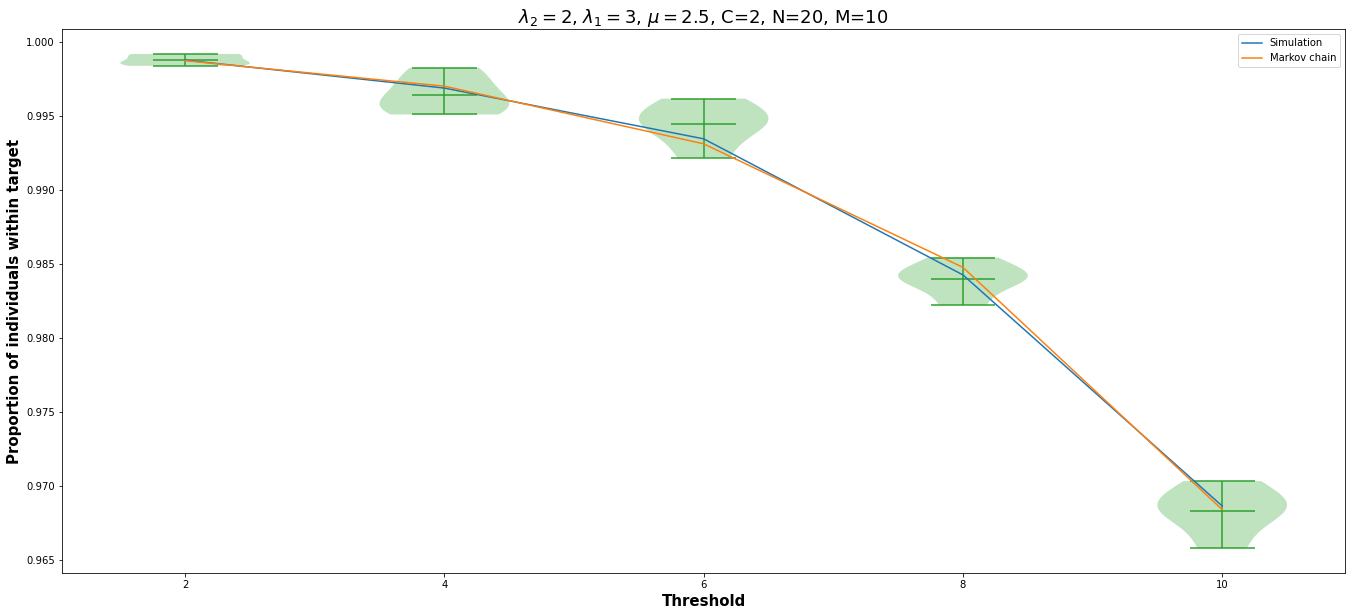

In [30]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

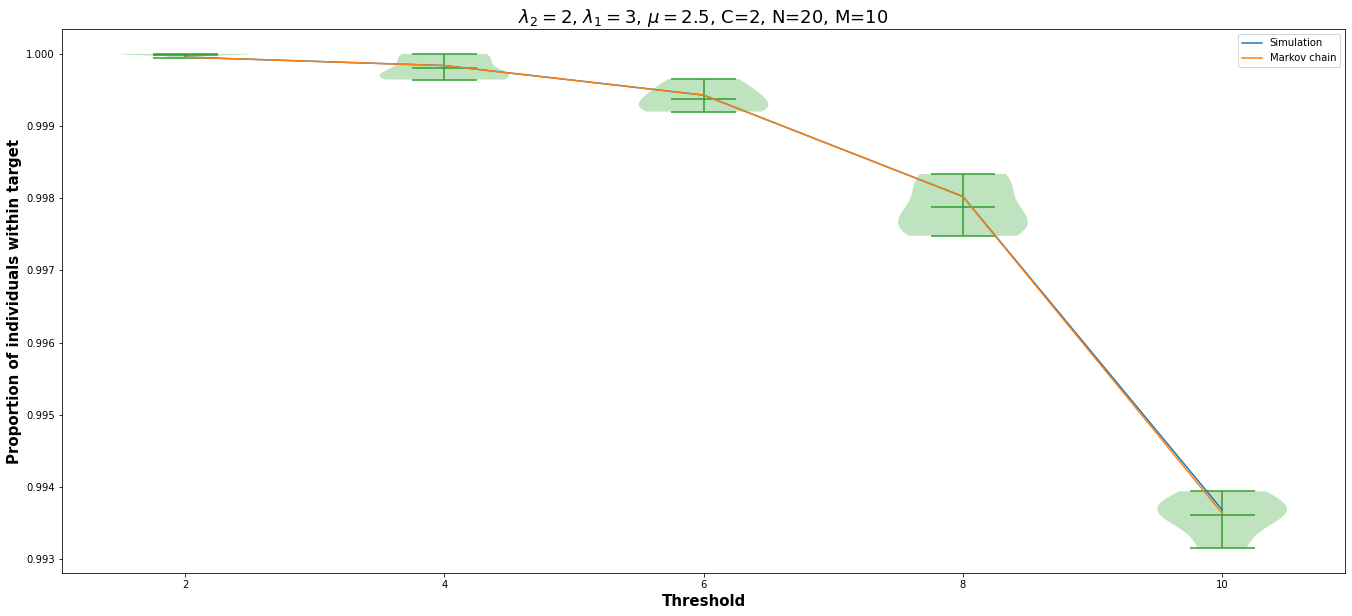

In [31]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

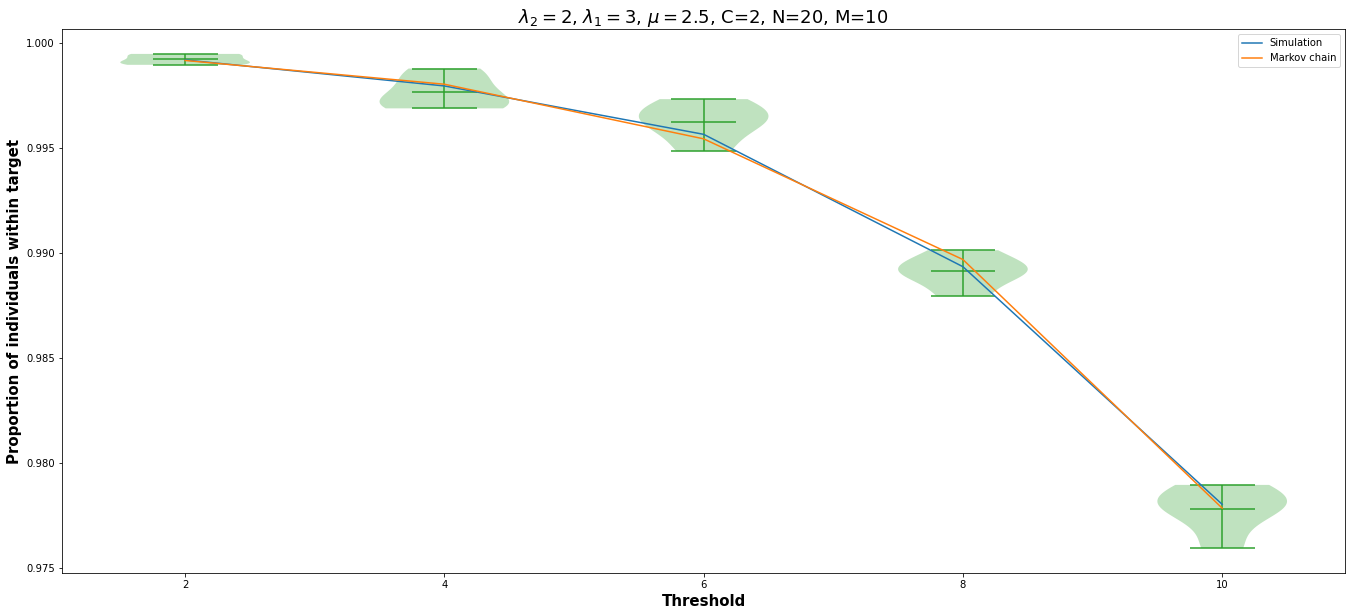

In [32]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = \frac{1}{2}, \lambda_2 = \frac{1}{2}, \mu = \frac{1}{2}, C = 3, T_{\min} = 2, T_{\max} = 6, N = 6, M = 5$

In [33]:
lambda_1 = 0.5
lambda_2 = 0.5
mu = 0.5

num_of_servers = 3
system_capacity = 6
buffer_capacity = 5

seed_num = 3
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 6
accuracy = 5
target = 4

## Class 1

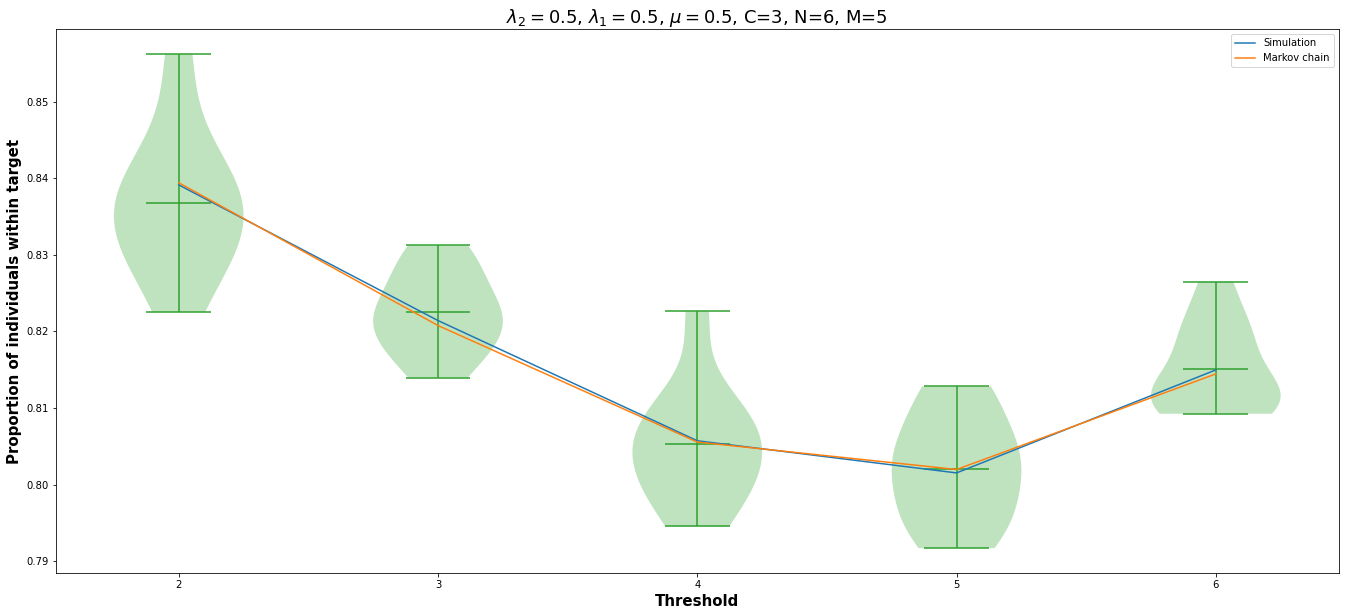

In [34]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

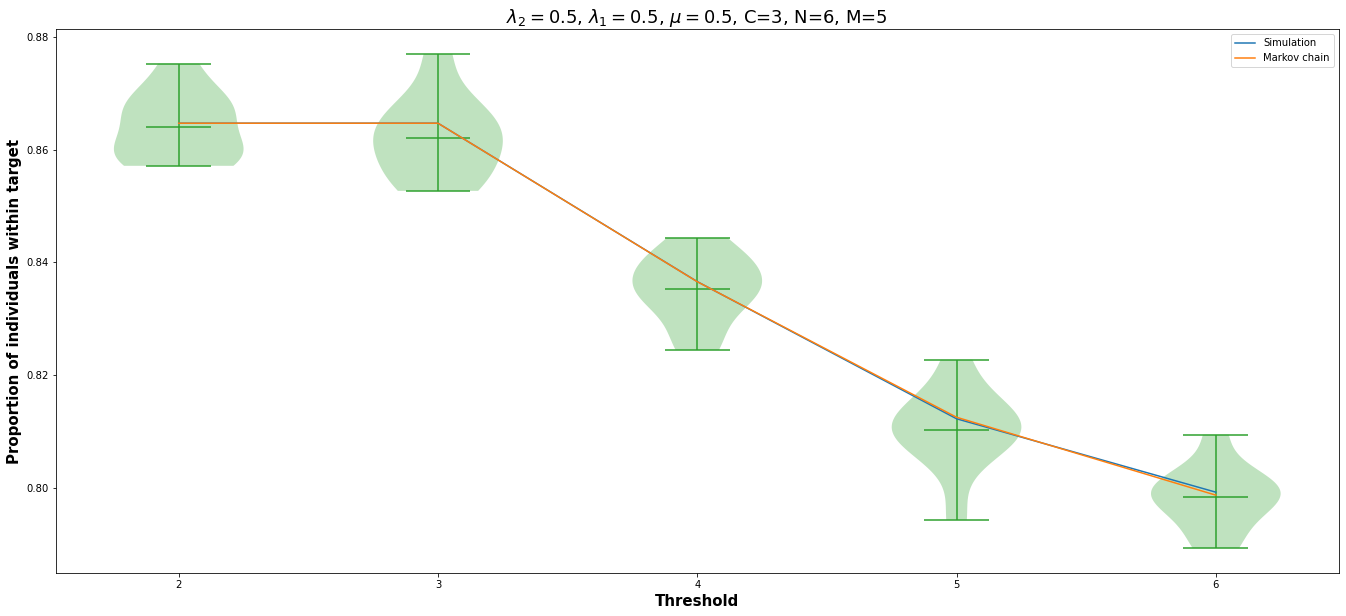

In [35]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

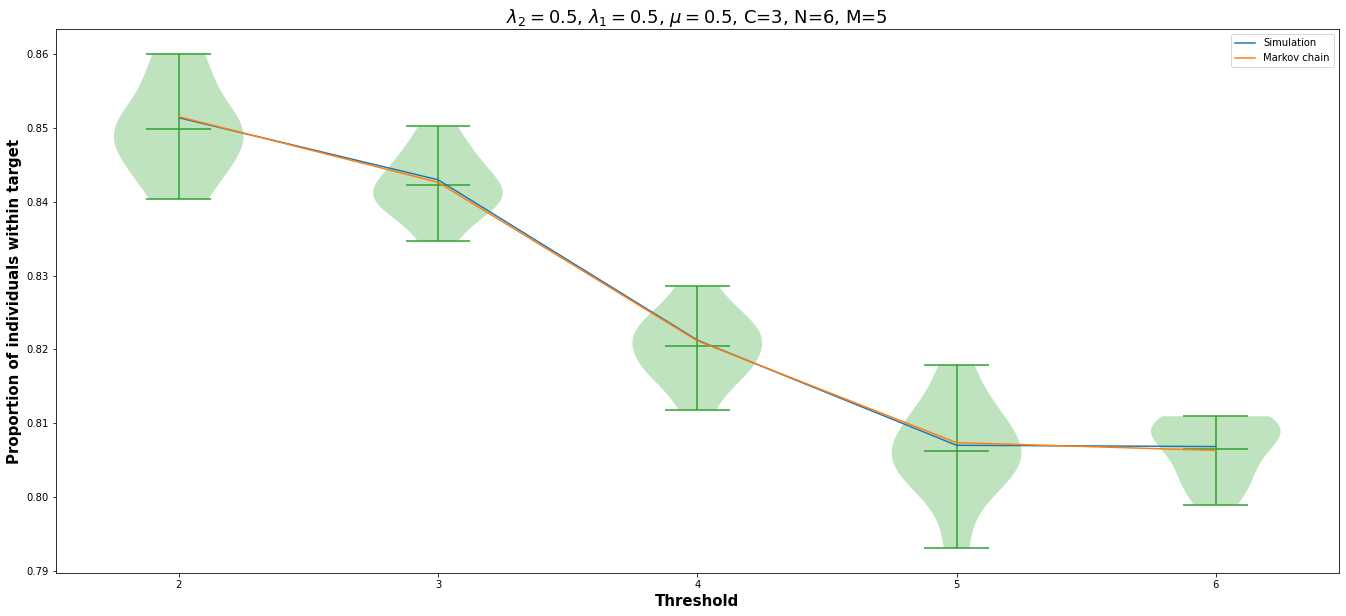

In [36]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 1, \lambda_2 = 2, \mu = 4, C = 1, T_{\min} = 2, T_{\max} = 10, N = 15, M = 15$

In [37]:
lambda_1 = 1
lambda_2 = 2
mu = 4

num_of_servers = 1
system_capacity = 15
buffer_capacity = 15

seed_num = None
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

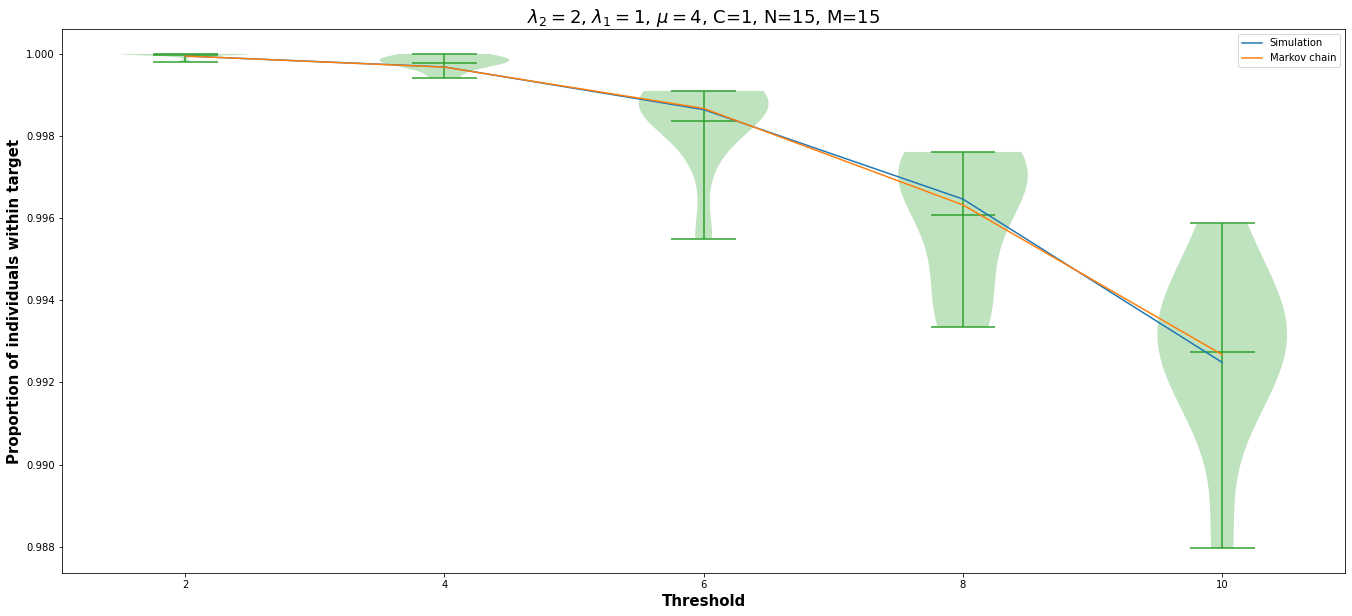

In [38]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

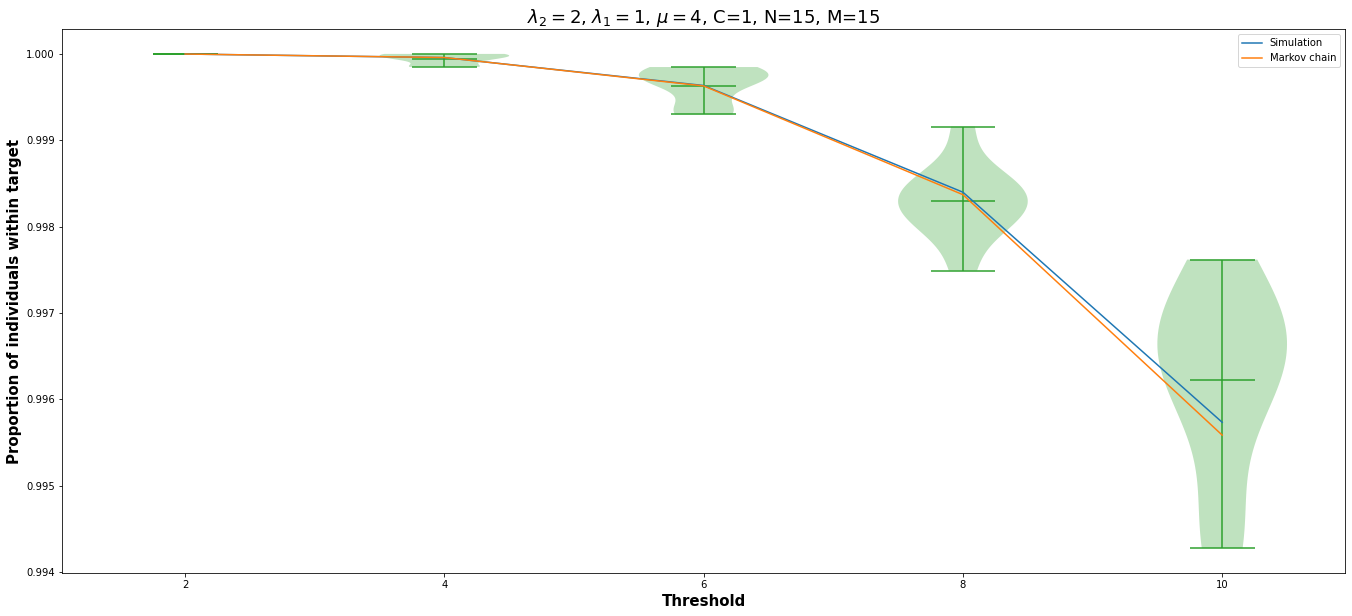

In [39]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

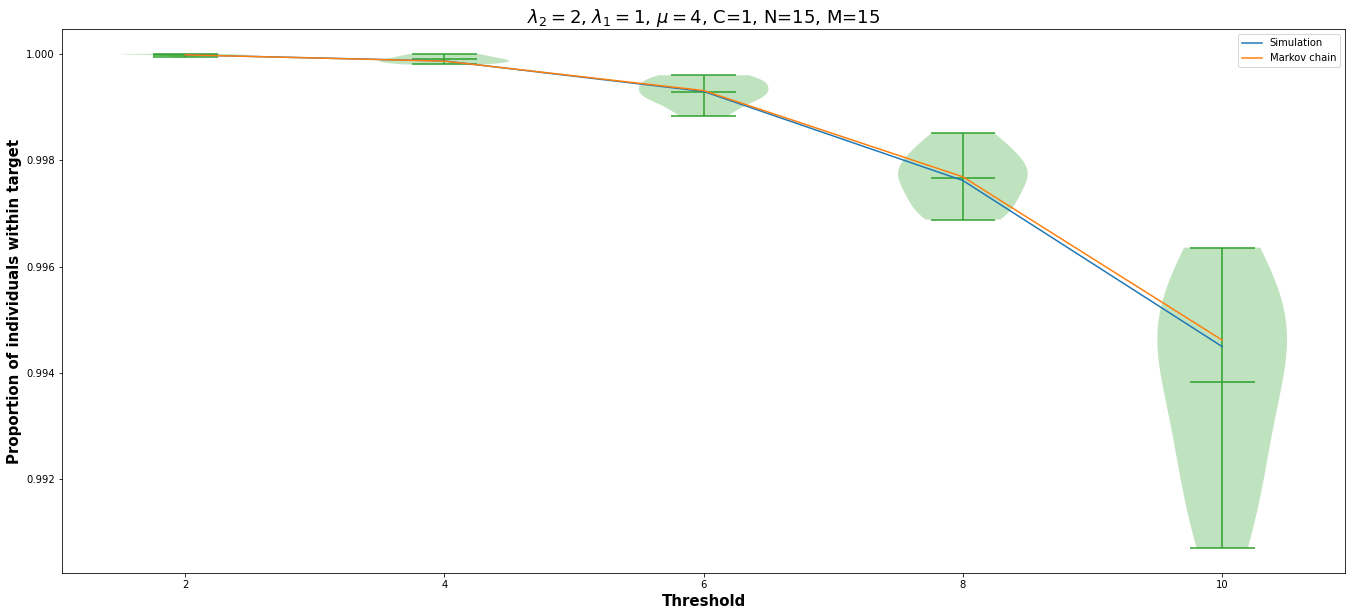

In [40]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

# Testing

In [19]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

seed_num = 2
num_of_trials = 2
runtime = 100

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

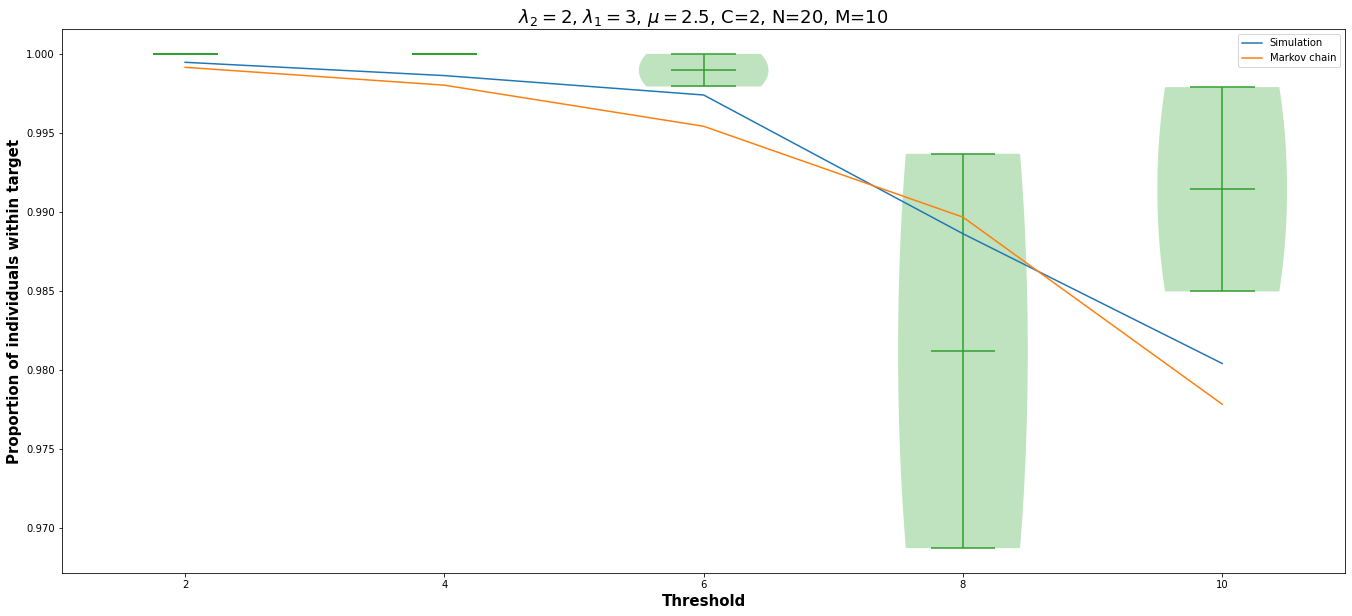

In [21]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

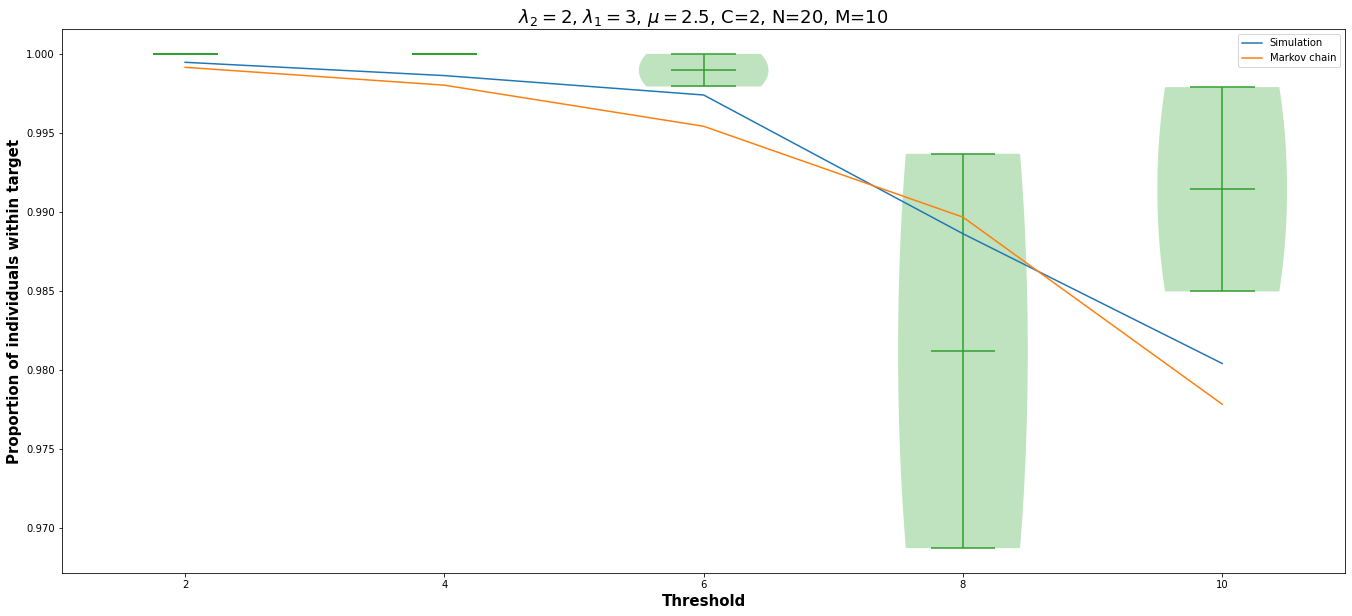

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

### Compare outputs of $\Psi$ functions

In [22]:
general_psi_function(arg=0.0001, k=2, l=1, exp_rates=(0, 4, 2), freq=(1, 10, 1), a=2)

-0.009534359306064256

In [24]:
for l in range(1, 20):
    assert (
        round(general_psi_function(arg=10, k=1, l=l, exp_rates=(0, 6, 3), freq=(1, 10, 1), a=2))
        == round(specific_psi_function(arg=10, k=1, l=l, exp_rates=(0, 6, 3), freq=(1, 10, 1), a=2))
    )

In [25]:
for l in range(1, 20):
    assert (
        round(general_psi_function(arg=30, k=1, l=l, exp_rates=(0, 10, 2), freq=(1, 20, 1), a=2))
        == round(specific_psi_function(arg=30, k=1, l=l, exp_rates=(0, 10, 2), freq=(1, 20, 1), a=2))
    )

### Testing other functions

In [187]:
all_states = [(0,0), (0,1), (0,2), (1,2), (0,3), (1,3)]
pi=np.array([[0.1, 0.2, 0.2, 0.3], [0, 0, 0, 0.2]])
overall_proportion_of_individuals_within_time_target(
    all_states=all_states, 
    pi=pi,  
    lambda_1=2,
    lambda_2=2,
    threshold=2, 
    system_capacity=3, 
    buffer_capacity=1, 
    target=1,
    psi_func=specific_psi_function,
)

0.9063231472799761

In [27]:
all_states = [(0,0), (0,1), (0,2), (1,2), (0,3), (1,3)]
pi=np.array([[0.1, 0.2, 0.2, 0.3], [0, 0, 0, 0.2]])
overall_proportion_of_individuals_within_time_target(
    all_states=all_states, 
    pi=pi,  
    lambda_1=2,
    lambda_2=2,
    mu=2.5,
    num_of_servers=2,
    threshold=2, 
    system_capacity=3, 
    buffer_capacity=1, 
    target=1,
    psi_func=specific_psi_function,
)

0.9063231472799761

In [21]:
proportion_within_target_using_markov_state_probabilities(
    lambda_1=2, 
    lambda_2=2, 
    mu=3, 
    num_of_servers=2, 
    threshold=2, 
    system_capacity=3, 
    buffer_capacity=1, 
    class_type=1,
    target=1,
    psi_func=specific_psi_function,
)

0.8646647167633873

In [28]:
proportion_within_target_using_markov_state_probabilities(
    lambda_1=2, 
    lambda_2=2, 
    mu=3, 
    num_of_servers=2, 
    threshold=2, 
    system_capacity=3, 
    buffer_capacity=1, 
    class_type=1,
    target=1,
    psi_func=specific_psi_function,
)

0.9502129316321362

In [32]:
def demo_specific_psi_function(arg, k, l, exp_rates, freq, a):
    if k == 1:
        psi_val = (1 / (arg ** l)) - (1 / (arg + exp_rates[2]) ** l)
        psi_val *= (-1) ** l * math.factorial(l - 1) / exp_rates[2]
        return psi_val
    if k == 2:
        psi_val = -1 / (arg * (arg + exp_rates[1]) ** freq[1])
        return psi_val

In [30]:
general_psi_function(
    arg=2, k=1, l=7, exp_rates=(0, 9, 3), freq=(1, 15, 1), a=2
)

-1.871928

In [31]:
specific_psi_function(
    arg=2, k=1, l=7, exp_rates=(0, 9, 3), freq=(1, 15, 1), a=2
)

-1.871928

In [50]:
all_states = [(0, 0), (0, 1), (0, 2), (1, 2), (0, 3), (1, 3)]
pi = np.array([[0.1, 0.1, 0.1, 0.3], [np.nan, np.nan, 0.2, 0.2]])
get_proportion_of_individuals_within_time_target(
    all_states=all_states,
    pi=pi,
    class_type=1,
    mu=1,
    num_of_servers=1,
    threshold=2,
    system_capacity=3,
    buffer_capacity=1,
    target=4,
    psi_func=specific_psi_function,
)

0.9206322314821518

In [57]:
prop = proportion_within_target_using_markov_state_probabilities(
        lambda_1=2,
        lambda_2=2,
        mu=3,
        num_of_servers=2,
        threshold=2,
        system_capacity=3,
        buffer_capacity=1,
        class_type=1,
        target=1,
        psi_func=specific_psi_function,
    )

In [58]:
prop

0.9502129316321362

In [23]:
get_proportion_within_target_from_simulation_state_probabilities(
    lambda_1=1,
    lambda_2=1,
    mu=1,
    num_of_servers=3,
    threshold=7,
    system_capacity=10,
    buffer_capacity=5,
    target=4,
    class_type=0,
    seed_num=0,
    num_of_trials=2,
    runtime=100,
)

0.9605868280871762

(array([ 2,  4,  6,  8, 10]), [0.9803420072819845, 0.973534925815833, 0.965115375542696, 0.955970978810005, 0.947016739750006], [0.9793015428995077, 0.9737157940379565, 0.966029525931023, 0.959257362821785, 0.9542079250880933], [[0.9786096256684492, 0.9938650306748467], [0.9622641509433962, 0.9777777777777777], [0.9481132075471698, 0.9777777777777777], [0.9292452830188679, 0.9777777777777777], [0.910377358490566, 0.9777777777777777]])


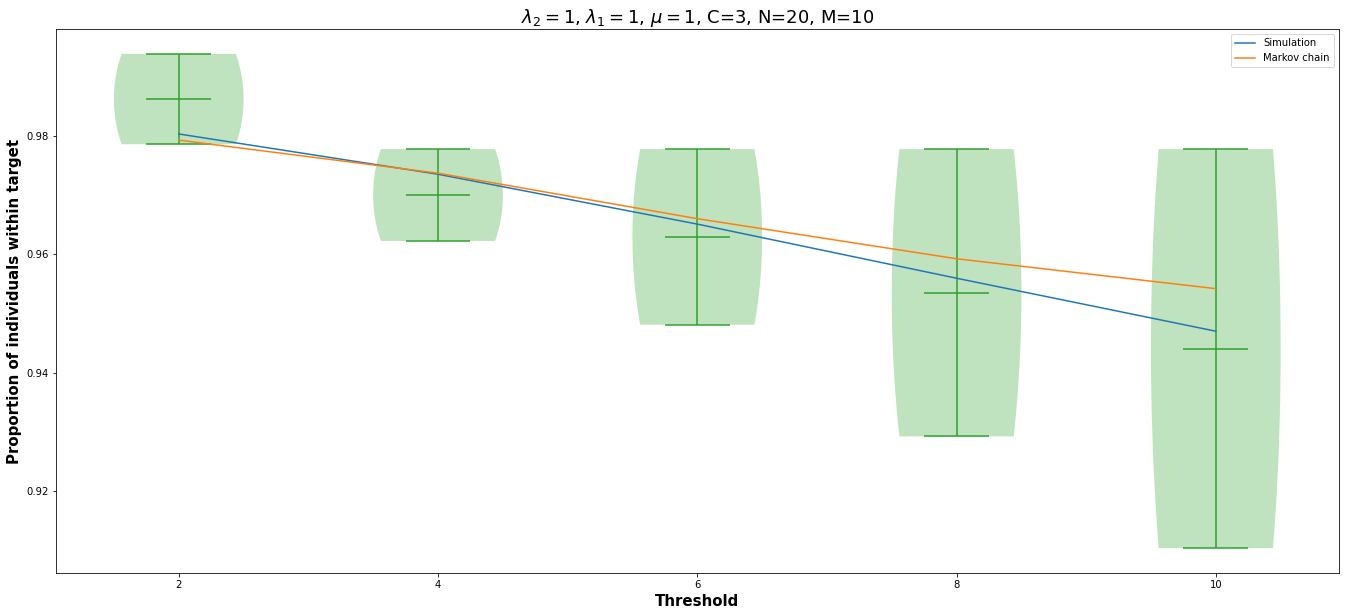

In [38]:
out = plot_of_proportion_within_target(
    lambda_1=1,
    lambda_2=1,
    mu=1,
    num_of_servers=3,
    min_threshold=2,
    max_threshold=10,
    system_capacity=20,
    buffer_capacity=10,
    seed_num=1,
    num_of_trials=2,
    runtime=100,
    target=4,
    class_type=None,
    accuracy=5,
)
print(out)

(array([ 2.,  4.,  6.,  8., 10.]),
 [0.9803420072819845,
  0.973534925815833,
  0.965115375542696,
  0.955970978810005,
  0.947016739750006],
 [0.9793015428995077,
  0.9737157940379565,
  0.966029525931023,
  0.959257362821785,
  0.9542079250880933],
 [[0.9786096256684492, 0.9938650306748467],
  [0.9622641509433962, 0.9777777777777777],
  [0.9481132075471698, 0.9777777777777777],
  [0.9292452830188679, 0.9777777777777777],
  [0.910377358490566, 0.9777777777777777]])

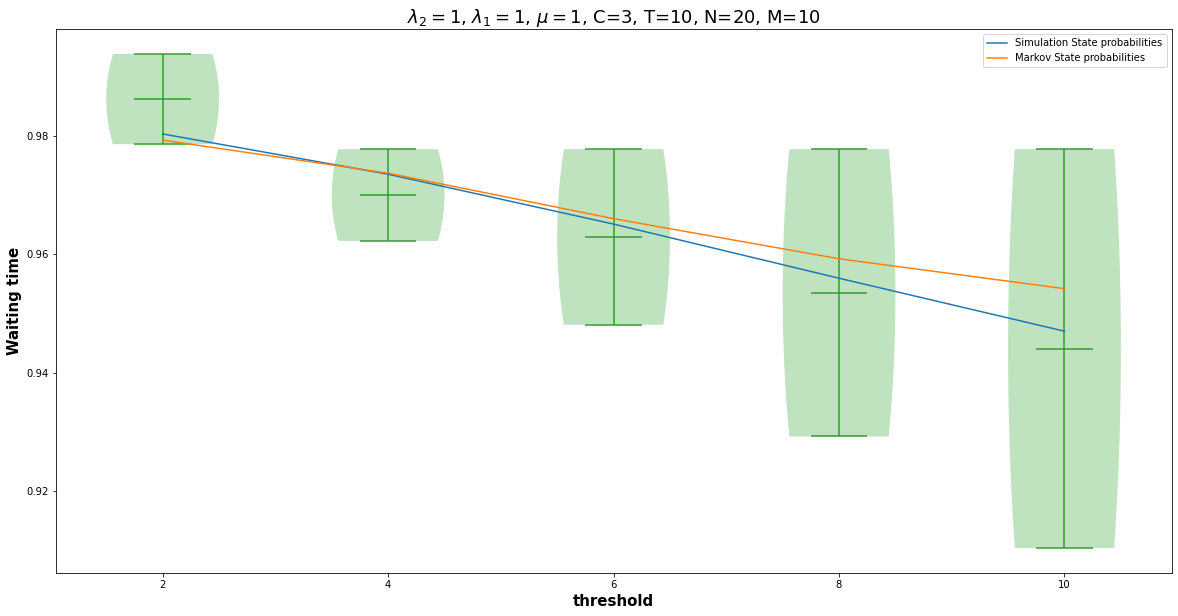

In [21]:
out = plot_output_comparisons(
    lambda_1=1,
    lambda_2=1,
    mu=1,
    num_of_servers=3,
    threshold=2,
    system_capacity=20,
    buffer_capacity=10,
    seed_num=1,
    num_of_trials=2,
    runtime=100,
    target=4,
    class_type=None,
    measure_to_compare="proportion",
    accuracy=5,
    plot_over="threshold",
    max_parameter_value=10,
)
out